# Univariate time series forecasting:

In this code the results of timeseries forecasting for 12 different datasets have been collected. One-step ahead recursive forecasting have been used on each one of them as a univariate time series forecasting problem.
The collected data has been plotted based on metrics used. RMSE (root mean squared error) and MSLE (mean logarithmic squared error) have been used as our metrics for comparison.

List of approaches:
- classical methods such as SARIMA or ARIMA
- Multilayar Perceptron (MLP)
- Stacked Unidirectional and Bidirectional Long Short Term Memory networks (LSTM)
- Recurrent Neural Networks (RNN)
- Gated Recurrent Unit (GRU)
- Convolution based networks (CNN-LSTM)
- Dilated Causal Convolutions (DC-CNN)
- SeriesNet
- WaveNet

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import keras
import tensorflow
import statsmodels.tsa as sm 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMAResults, ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import seaborn as sns
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Activation, Bidirectional, Flatten, TimeDistributed, SimpleRNN, Dropout, GRU, Input, Add, Multiply
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras import optimizers, initializers
from keras.regularizers import l2
from keras.initializers import TruncatedNormal, Constant, RandomNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
import pickle
%matplotlib inline

In [4]:
np.random.seed(2019) # for initializing models with same weights every time.
from tensorflow import set_random_seed
set_random_seed(2019)
validation_split = 0.25 #for train-test split of dataset.

In [5]:
#metrics:
#root mean squared error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#mean absolute percentage error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

#symmetric mean absolute error
def SMAPE(y_true, y_pred):
    smape = 100/len(y_true) * np.sum(2 * np.abs(np.array(y_pred) - np.array(y_true)) / (np.abs(np.array(y_true)) + np.abs(np.array(y_pred))))
    return smape

#mean squared logarithmic error:
def MSLE(y_true, y_pred):
    rmse = mean_squared_log_error(y_true, y_pred)
    return rmse

# Importing Dataset and Plotting:

This Dataset has been taken from: https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

It is a daily stock price of US companies.

The goal is to perfrom univariate time series forecasting via one-step ahead recursive forecasting. Performance of classical methods and deep learning approaches will be compared to each other.

ADF test results: (-3.1184724787047085, 0.025216003299528476, 0, 988, {'1%': -3.4369860032923145, '5%': -2.8644697838498376, '10%': -2.5683299626694422}, -3961.899432049059)
High p-value of ADF test (0.025216003299528476) shows that we fail to reject null hypothesis. 
 Hence, the dataset is non-stationary.


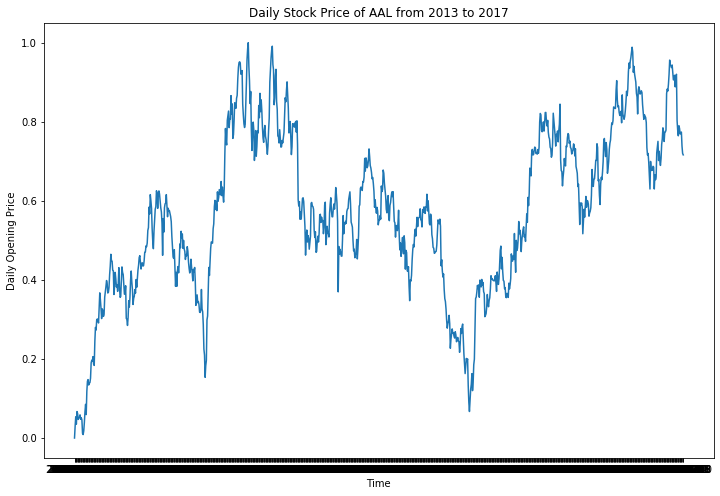

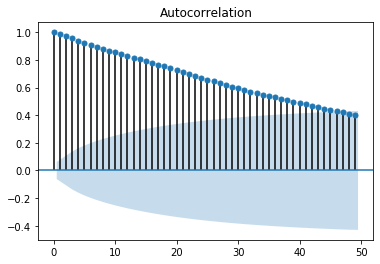

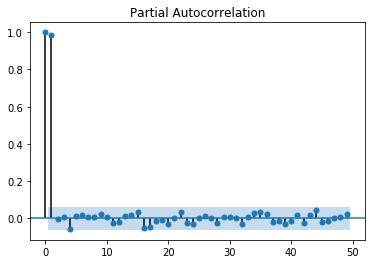

In [10]:
aal = pd.read_csv('/home/ahmada59/Datasets/US-Stocks/Stocks/aal.us.txt', sep = ',')
aal.set_index('Date', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame({"Open":scaler.fit_transform(np.array(aal['Open']).reshape(len(aal),1)).reshape(len(aal),)},
                  index = aal.index)
plt.figure(figsize=(12,8))
plt.plot(df)
plt.xlabel('Time')
plt.ylabel('Daily Opening Price')
plt.title('Daily Stock Price of AAL from 2013 to 2017')
plt.savefig('fig1.png', dpi=800, quality=95)
tsaplots.plot_acf(df, ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_pacf(df, ax=None, lags=np.arange(50), use_vlines=True)
print("ADF test results:", sm.stattools.adfuller(df.iloc[:,0], autolag='AIC'))
print('High p-value of ADF test ({}) shows that we fail to reject null hypothesis. \n Hence, the dataset is non-stationary.'.format(sm.stattools.adfuller(df.iloc[:,0], autolag='AIC')[1]))

ACF and PACF plots display significant correlation between lags, and hence data is non-stationary. One approach is to take out trend by rolling average and make it stationar for classical analysis.

Manually decomposing trend and seasonality:
 - taking out trend by moving average smoothing method

/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


ADF test results: (-10.77270291371927, 2.1522184775715455e-19, 4, 974, {'1%': -2.568039305769304, '5%': -1.9412792832785186, '10%': -1.6165501434408924}, -3999.4435330200486)
low p-value of ADF test (1.9838252084184372e-19) shows that we will reject null hypothesis. 
 Hence, the residual is close to stationary.
P-value of ADF test on the noise (with no constant no trend) shows that data is stationary.
 Hence, we can say that data is trend stationary.


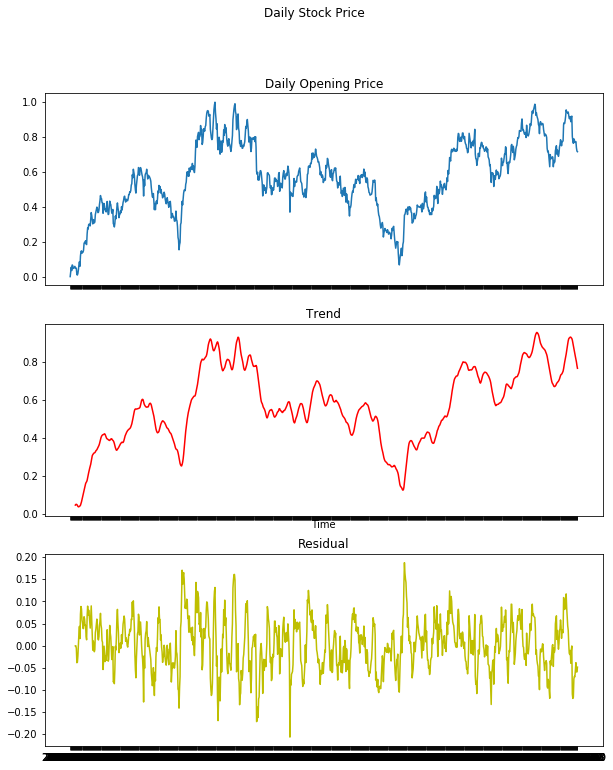

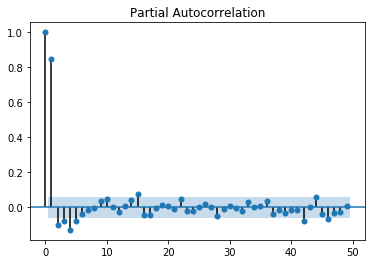

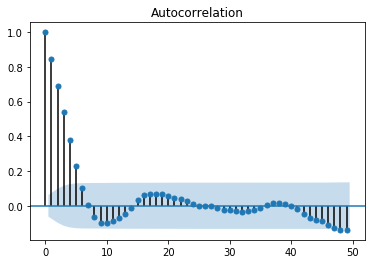

In [11]:
trendcomp = (df.rolling(10).mean()).rolling(2).mean()
res = (df - trendcomp).dropna()
#taking month-wise averages for seasonality
#month = res.index.map(lambda d: d[5:7])
#res1 = res.groupby(by = month).aggregate(['mean'])
#seasonalcomp = [0 for i in range(len(trendcomp))]
#for i in range(len(trendcomp)):
#    seasonalcomp[i] = res1[res1.index == trendcomp.index[i].split(sep='-')[1]].values.reshape(1,).tolist()
noise = df.iloc[:,0] - trendcomp.iloc[:,0] #- np.array(seasonalcomp).reshape(len(df),)
df['trendcomp'] = trendcomp.values
#df['seasonalcomp'] = np.array(seasonalcomp).reshape((len(df),1))
df['noise'] = noise.values
fig = plt.figure(1, figsize=[10,12])
fig.suptitle('Daily Stock Price')
fig1, fig2, fig4 = fig.subplots(nrows=3, ncols=1, sharex=True, sharey=False)
fig1.set_title('Daily Opening Price')
fig2.set_title('Trend')
#fig3.set_title('Seasonality')
fig4.set_title('Residual')
fig2.set_xlabel('Time')
fig1.plot(df.loc[:,'Open'])
fig2.plot(df.loc[:,'trendcomp'], 'r')
#fig3.plot(df.loc[:,'seasonalcomp'], 'g')
fig4.plot(df.loc[:,'noise'], 'y')
fig.show()
# taking auto correlations for stationary residual.
tsaplots.plot_pacf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_acf(noise.dropna(), ax=None, lags=np.arange(50), use_vlines=True)
#ADF test on residual
print("ADF test results:", sm.stattools.adfuller(df.loc[:,'noise'].dropna(), regression='nc', autolag='AIC'))
print('low p-value of ADF test ({}) shows that we will reject null hypothesis. \n Hence, the residual is close to stationary.'.format(sm.stattools.adfuller(df.loc[:,'noise'].dropna(), autolag='AIC')[1]))
print('P-value of ADF test on the noise (with no constant no trend) shows that data is stationary.\n Hence, we can say that data is trend stationary.')

As we can see, it is not easy to take out the trend component by rolling average. Another method is to perform differencing on the dataset.

Manually decompose of seasonality and trend: 
    - differencing method to see if time series is difference stationary!

ADF test results: (-31.104264524712725, 0.0, 0, 987, {'1%': -2.5680089714002396, '5%': -1.941275559544345, '10%': -1.6165536613071498}, -3949.9758987458845)
low p-value of ADF test (0.0) shows that we will reject null hypothesis. 
 Hence, the residual is close to stationary.
Data is not getting stationary by multiple differencings. So data is trend stationary.


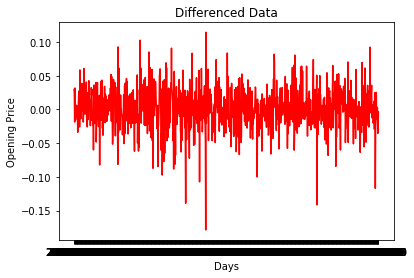

In [14]:
diff1 = df.loc[:,'Open'].diff(1)
nn = diff1.dropna() # - df.seasonalcomp[1:]
plt.plot(nn,'r')
plt.title('Differenced Data')
plt.xlabel('Days')
plt.ylabel('Opening Price')

# ADF test on difference data:
print("ADF test results:", sm.stattools.adfuller(nn, regression='nc', autolag='AIC'))
print('low p-value of ADF test ({}) shows that we will reject null hypothesis. \n Hence, the residual is close to stationary.'.format(sm.stattools.adfuller(nn, regression='nc', autolag='AIC')[1]))
print('Data is not getting stationary by multiple differencings. So data is trend stationary.')

# Train Test Split:

In [15]:
trainfrac = 0.75
df_train, df_test = train_test_split(df, train_size=trainfrac, shuffle=False, stratify=None)

# ARIMA

Finding best arima model and fitting:

In [16]:
results = pd.DataFrame({"p": [], "d": [], "q":[], "aic": []})
results = results[['p','d','q','aic']]
for d in range(0,3):
    for p in range(0,3):
        for q in range(0,3):
            try:
                df_arima = sm.arima_model.ARIMA(df_train.loc[:,'Open'].tolist(), order=(p,d,q))
                #the value of start_params defines that the model will converge or not.
                #values equal or greater than 1 won't converge at all. Values less than 1 will most probably 
                #converge. If not, try decreasing the parameters to lower values.
                df_arima_fit = df_arima.fit(start_params=0.1*np.ones(p+q+1))
                dd = pd.DataFrame({'p':[p], 'd':[d], 'q':[q], 'aic':[df_arima_fit.aic]})
                dd = dd[['p','d','q','aic']]
                results = results.append(dd)
            except ValueError:
                pass
print("p", "d", "q", "    AIC\n", sep='        ')
for i in range(results.shape[0]):
    print("{0:1d}, {1:7d}, {2:7d}, {3:17f}\n".format(results.values[i][0].astype('int64'), results.values[i][1].astype('int64'), results.values[i][2].astype('int64'), results.values[i][3]))
opt_arima = (results[results.loc[:,'aic'] == results['aic'].min()].values[0]).astype('int64')
print(" - The minimum AIC value can be obtained by p={}, d={}, q={} paramteres.".format(opt_arima[0],opt_arima[1], opt_arima[2]))
print(" - ARIMA({},{},{}) will be chosen as the best model.".format(opt_arima[0],opt_arima[1], opt_arima[2]))

/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'avail

p        d        q            AIC

0,       0,       0,       -316.752630

0,       0,       1,      -1177.490202

0,       0,       2,      -1733.625007

1,       0,       0,      -3004.820433

1,       0,       1,      -3003.052926

1,       0,       2,      -3001.438278

2,       0,       0,      -3003.063922

2,       0,       1,      -3001.570691

2,       0,       2,      -3003.262040

0,       1,       0,      -3004.347119

0,       1,       1,      -3002.437620

0,       1,       2,      -3000.646608

1,       1,       0,      -3002.440682

1,       1,       1,      -3000.648734

1,       1,       2,      -2998.932475

2,       1,       0,      -3000.662410

2,       1,       1,      -2998.892905

2,       1,       2,      -3002.623137

0,       2,       0,      -2495.891830

0,       2,       1,      -2991.146307

0,       2,       2,      -2989.249918

1,       2,       0,      -2709.862419

1,       2,       1,      -2989.253451

1,       2,       2,      -2991.482750

2,  

/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [17]:
df_arima = sm.arima_model.ARIMA(df_train['Open'].tolist(), order=(opt_arima[0],opt_arima[1],opt_arima[2]))
df_arima_fit = df_arima.fit(start_params=0.1*np.ones(opt_arima[0]+opt_arima[2]+1))
df_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  741
Model:                     ARMA(1, 0)   Log Likelihood                1505.410
Method:                       css-mle   S.D. of innovations              0.032
Date:                Wed, 11 Dec 2019   AIC                          -3004.820
Time:                        19:12:01   BIC                          -2990.996
Sample:                             0   HQIC                         -2999.491
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4707      0.104      4.536      0.000       0.267       0.674
ar.L1.y        0.9899      0.006    179.673      0.000       0.979       1.001
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0102           +0.0000j            1.0102            0.0000
-----------------------------------------------------------------------------
"""

Saving/Loading ARIMA results:

In [18]:
df_arima_fit.save('/home/ahmada59/py/AAL_ARIMA.pkl')
#df_arima_fit = ARIMAResults.load('CO2Concentrations_SARIMA.pkl')

Evaluating arima model:

/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/pandas/core/indexing.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

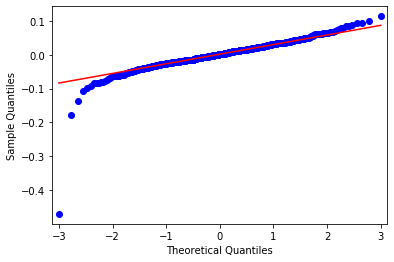

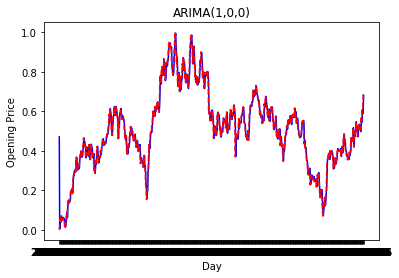

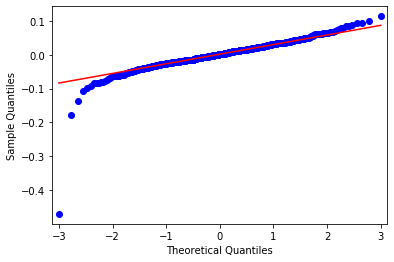

In [19]:
df_train.loc[opt_arima[1]:,'ARIMA'] = np.append([], df_arima_fit.fittedvalues)
df_train.loc[opt_arima[1]:,'diff'] = np.append([], df_arima_fit.fittedvalues + df_arima_fit.resid)
plt.plot(df_train.loc[:,'ARIMA'], 'b-', df_train.loc[:,'diff'], 'r--')
plt.xlabel('Day')
plt.ylabel('Opening Price')
plt.title('ARIMA({},{},{})'.format(opt_arima[0],opt_arima[1], opt_arima[2]))
# plotting qq plot for normality check of residuals to iid noise
qqplot(data=df_arima_fit.resid, loc=0.0, scale=1.0, line='q')

As we can see the QQ-plot on the residuals of the arima model is close to normal. Hence we can deduce that the order of parameters are suitable to take the behaviour of the time series.

Here there is no need for SARIMA as dataset shows no seasonality.

We also plot ACF and PAC>F plots for the residual to make sure there is no correlation between lags of residuals and it is stationary (iid noise).

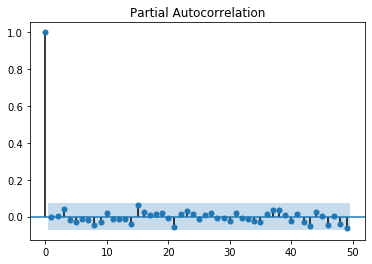

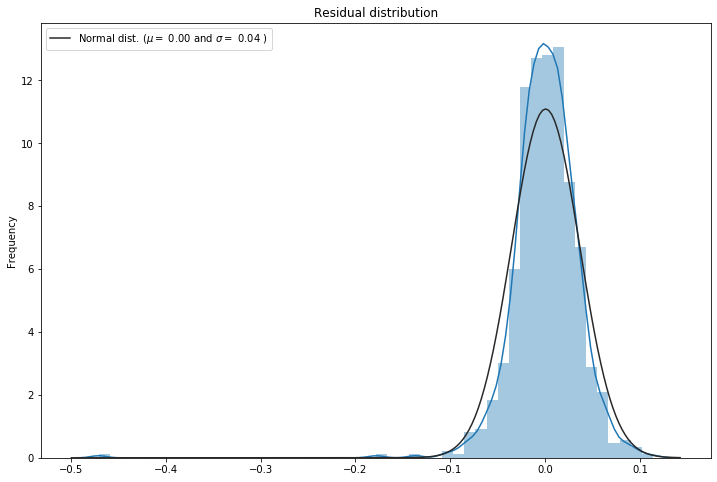

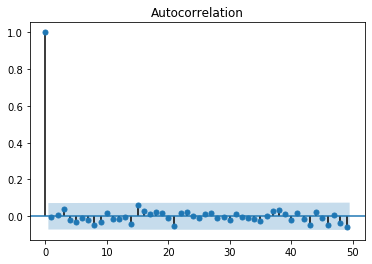

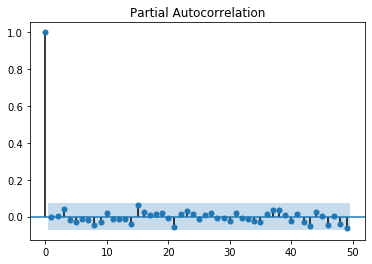

In [20]:
# Checking if the residuals are iid noise.
resid = df_arima_fit.resid
fig = plt.figure(figsize=(12,8))
sns.distplot(resid, fit=stats.norm)
(mu, sigma) = stats.norm.fit(resid)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')
tsaplots.plot_acf(resid, ax=None, lags=np.arange(50), use_vlines=True)
tsaplots.plot_pacf(resid, ax=None, lags=np.arange(50), use_vlines=True)

One-step ahead recursive forecasting using ARIMA results:

/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


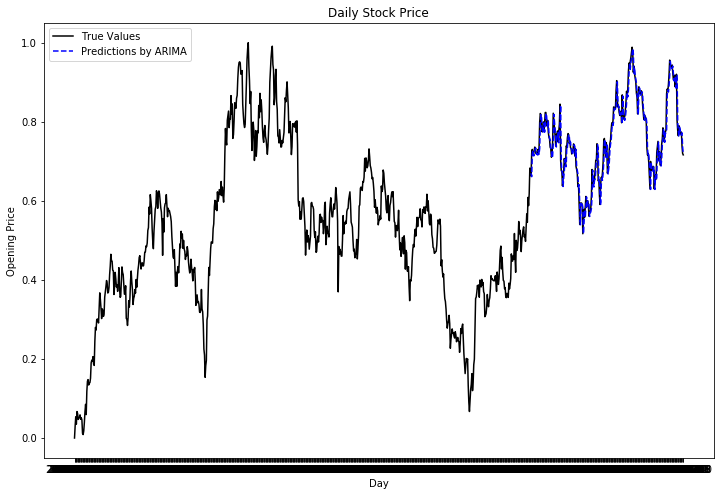

In [21]:
def sarima_forecast_recursive(history, config, n):
    model = sm.arima_model.ARIMA(history, order=config['order'])
    fittedmodel = model.fit(start_params = np.ones(n)*0.1)
    forecast = fittedmodel.forecast(steps=1, alpha=0.05)
    return forecast

# config referes to sarima model that is the same for recursive forecasting.
config = {"order":[opt_arima[0],opt_arima[1],opt_arima[2]]}
history = df_train['Open'].tolist()
predictions = []
n = config['order'][0]+config['order'][2]+1

for i in range(len(df_test)):
    yhat = sarima_forecast_recursive(history, config, n)
    predictions.append(yhat[0])
    history.append(df_test['Open'][i])

df_forecasted_SARIMAX = pd.DataFrame(index=df.index[math.floor(len(df)*trainfrac):].tolist(),
                                     data={'forecast': predictions})
plt.figure(figsize=(12,8))
plt.plot(df.loc[:,'Open'], 'k', df_forecasted_SARIMAX, 'b--')
plt.xlabel('Day')
plt.ylabel('Opening Price')
plt.title('Daily Stock Price')
plt.legend(['True Values', 'Predictions by ARIMA'], loc='best')
plt.show()

Calculatin the metrics of our model:

In [22]:
rmse_arima = RMSE(df_test['Open'].tolist(), predictions)
mape_arima = MAPE(df_test['Open'].tolist(), predictions)
smape_arima = SMAPE(df_test['Open'].tolist(), predictions)
msle_arima = MSLE(df_test['Open'].tolist(), predictions)
# Metrics is a dictionary to save metrics results for different methods.
Metrics = {"RMSE_ARIMA": rmse_arima, "MAPE_ARIMA": mape_arima, "SMAPE_ARIMA": smape_arima,
          "MSLE_ARIMA": msle_arima}
Metrics

{'RMSE_ARIMA': 0.028961775944481898,
 'MAPE_ARIMA': 15.086972725254943,
 'SMAPE_ARIMA': 3688.863670027969,
 'MSLE_ARIMA': 0.0002764741351409335}

# Time series analysis using deep learning

Preparing data set:

In [24]:
#this function generates the input output
def input_output_generator(z,n):
    #generating input output sets for mlp models
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

Building models and tuning parameters:

In [77]:
def Model_Build(Type,nodes,X_train, optimizer, learning_rate):
    # this function creates the model. Type is the type of deep learning model. It could be MLP, LSTM, ...
    # Nodes defines the sequence of nodes in different layers of network. It should be a list.
    # Optimizer and learning rate are used for compiling the model
    model = Sequential()
    if Type == 'MLP':
        model.add(Dense(nodes[0], activation='relu', input_shape=(X_train.shape[1],),
                        kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        for i in range(len(nodes)-1):
            model.add(Dense(nodes[i+1], activation='relu', kernel_initializer='random_uniform',
                            bias_initializer='RandomNormal'))

    if Type == 'Vanilla LSTM':
        model.add(LSTM(nodes, activation='relu', kernel_initializer='RandomNormal',
                       input_shape=(X_train[1,:].shape)))
        model.add(Dense(1))
    
    if Type == 'Stacked Unidirectional LSTM':
        model.add(LSTM(nodes[0], activation='relu', kernel_initializer='random_uniform', 
                       bias_initializer='RandomNormal', return_sequences=True, input_shape=(X_train[1,:].shape)))
        for i in range(len(nodes)-1):
            retseq = True
            if (i+1) == (len(nodes)-1):
                retseq = False
            model.add(LSTM(nodes[i+1], activation='relu', kernel_initializer='random_uniform', 
                           bias_initializer='RandomNormal',return_sequences=retseq))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform',
                        bias_initializer='RandomNormal'))
    
    if Type == 'Bidirectional LSTM':
        model.add(Bidirectional(LSTM(nodes, activation='relu',
                                     kernel_initializer='random_uniform', bias_initializer='RandomNormal'),
                                merge_mode='ave', input_shape=(X_train[1,:].shape)))
        model.add(Dense(1))
    
    if Type == 'Stacked Bidirectional LSTM':
        model.add(Bidirectional(LSTM(nodes[0], activation='relu', return_sequences=True,
                                    kernel_initializer='random_uniform', bias_initializer='RandomNormal'),
                                merge_mode='ave', input_shape=(X_train[1,:].shape)))
        for i in range(len(nodes)-1):
            retseq = True
            if (i+1) == (len(nodes)-1):
                retseq = False
            model.add(Bidirectional(LSTM(nodes[i+1], activation='relu', return_sequences=retseq,
                                        kernel_initializer='random_uniform', bias_initializer='RandomNormal'),
                                   merge_mode='ave'))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform',
                       bias_initializer='RandomNormal'))
    
    if Type == 'SimpleRNN':
        if type(nodes) == int:
            model.add(SimpleRNN(nodes, input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'tanh',
                               kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        else:
            model.add(SimpleRNN(nodes[0], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'tanh',
                                return_sequences=True, kernel_initializer='random_uniform', 
                                bias_initializer='RandomNormal'))
            for i in range(len(nodes)-1):
                retseq = True
                if (i+1) == (len(nodes)-1):
                    retseq = False
                model.add(SimpleRNN(nodes[i+1], activation='tanh', return_sequences=retseq, 
                                    kernel_initializer='random_uniform',bias_initializer='RandomNormal'))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
    
    if Type == 'GRU':
        if type(nodes) == int:
            model.add(GRU(nodes, input_shape = (X_train.shape[1], X_train.shape[2]),
                          activation = 'tanh', return_sequences=False,
                         kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        else:
            model.add(GRU(nodes[0], input_shape = (X_train.shape[1], X_train.shape[2]),
                          activation = 'tanh', return_sequences=True,
                         kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
            for i in range(len(nodes)-1):
                retseq = True
                model.add(GRU(nodes[i+1], activation='tanh', return_sequences=retseq,
                             kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        #model.add(GRU(1, activation='tanh', return_sequences=False,
         #            kernel_initializer='random_uniform', bias_initializer='RandomNormal'))
        model.add(Dense(1, activation='relu', kernel_initializer='random_uniform', bias_initializer='RandomNormal'))


    if optimizer == 'SGD':
        sgd = optimizers.SGD(lr=learning_rate, momentum=0)
        model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy', 'mse'])
    if optimizer == 'RMSprop':
        rmsprop = optimizers.RMSprop(lr=learning_rate, rho=0.9)
        model.compile(loss='mean_squared_error', optimizer=rmsprop, metrics=['accuracy', 'mse'])
    if optimizer == 'Adagrad':
        adagrad = optimizers.Adagrad(lr=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adagrad, metrics=['accuracy', 'mse'])
    if optimizer == 'Adadelta':
        adadelta = optimizers.Adadelta(lr=learning_rate, rho=0.95)
        model.compile(loss='mean_squared_error', optimizer=adadelta, metrics=['accuracy', 'mse'])
    if optimizer == 'Adam':
        adam = optimizers.Adam(learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model


def Tune_epoch(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this funciton tunes number of epochs of the model.
    e = [0 for i in range(len(epochs))]
    ii = 0
    for i in epochs:
        model = Model_Build(Type,nodes,X_train, optimizer, learning_rate)
        history_lstm = model.fit(X_train, Y_train, validation_split=val_split, epochs=i, batch_size=batch_size, verbose=0, shuffle=False)
        e[ii] = history_lstm.history['val_loss'][-1]
        ii += 1
    return e

def Tune_nodes(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes number of nodes.
    e = {}
    if np.size(np.shape(nodes)) == 1:
        for i in nodes:
            model = Model_Build(Type, i, X_train, optimizer, learning_rate)
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[i] = history.history['val_loss'][-1]
    else:
        for i in range(np.shape(nodes)[0]):
            model = Model_Build(Type, nodes[i], X_train, optimizer, learning_rate)
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[i] = history.history['val_loss'][-1]
    return e

def Tune_optimizer(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the optimizer and the learning rate.
    e = {}
    for i in range(len(optimizer)):
        for j in range(len(learning_rate)):
            model = Model_Build(Type, nodes, X_train, optimizer[i], learning_rate[j])
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[optimizer[i]+', rate='+str(learning_rate[j])] = history.history['val_loss'][-1]
    return e

def Tune_batch(Type, X_train, Y_train, nodes, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the batch size.
    e = {}
    for i in batch_size:
        model = Model_Build(Type, nodes, X_train, optimizer, learning_rate)
        history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=i, verbose=0, shuffle=False)
        e[i] = history.history['val_loss'][-1]
    return e

# MLP

MLP can be used for univariate time series forecasting. 
The input to the first dense layer has this shape: [n_steps,]. n_steps is the lag of the time series
and n_features is the number of features per time step. For univariate time series, n_features is equal to 1.
n_samples is the number of samples we feed into depp network.

In [30]:
lag_mlp = 5 # lag is number of previous steps
X_train_mlp, Y_train_mlp, X_test_mlp, Y_test_mlp = input_output_generator(df['Open'].tolist(), lag_mlp)

In [21]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.01]
nodes = [64,32,8,1]
e = Tune_optimizer('MLP', X_train_mlp, Y_train_mlp, nodes, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

{'Adagrad, rate=0.001': 0.013062287667708006,
 'Adagrad, rate=0.01': 0.001646786416645425,
 'Adam, rate=0.001': 0.1769192713191328,
 'Adam, rate=0.01': 0.1769192713191328}

In [22]:
# tuning number of layers and nodes in MLP 
#we will give few candidates for comparing
nodes = [[200,100,50,1],[64,32,16,1],[128,64,16,1]]
e = Tune_nodes('MLP', X_train_mlp, Y_train_mlp, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

{0: 0.001221334832497751, 1: 0.1769192713191328, 2: 0.0011471839426793968}

In [23]:
nodes_mlp = [200, 100, 50, 1]

In [94]:
#tune batch size
batch = [5, 10, 30]
e = Tune_batch('MLP', X_train_mlp, Y_train_mlp, nodes_mlp, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

Building the model:

In [35]:
batch_size = 10
nodes_mlp = [100, 50, 20, 1]
optimizer = 'Adam'
learning_rate = 0.001

Train on 552 samples, validate on 184 samples
Epoch 1/200
552/552 [==============================] - 0s 368us/step - loss: 0.2199 - accuracy: 0.0000e+00 - mse: 0.2199 - val_loss: 0.0118 - val_accuracy: 0.0000e+00 - val_mse: 0.0118
Epoch 2/200
552/552 [==============================] - 0s 145us/step - loss: 0.0111 - accuracy: 0.0018 - mse: 0.0111 - val_loss: 0.0083 - val_accuracy: 0.0000e+00 - val_mse: 0.0083
Epoch 3/200
552/552 [==============================] - 0s 120us/step - loss: 0.0136 - accuracy: 0.0018 - mse: 0.0136 - val_loss: 0.0076 - val_accuracy: 0.0000e+00 - val_mse: 0.0076
Epoch 4/200
552/552 [==============================] - 0s 165us/step - loss: 0.0130 - accuracy: 0.0018 - mse: 0.0130 - val_loss: 0.0072 - val_accuracy: 0.0000e+00 - val_mse: 0.0072
Epoch 5/200
552/552 [==============================] - 0s 155us/step - loss: 0.0123 - accuracy: 0.0018 - mse: 0.0123 - val_loss: 0.0067 - val_accuracy: 0.0000e+00 - val_mse: 0.0067
Epoch 6/200
552/552 [========================

Epoch 46/200
552/552 [==============================] - 0s 127us/step - loss: 0.0025 - accuracy: 0.0018 - mse: 0.0025 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mse: 0.0016
Epoch 47/200
552/552 [==============================] - 0s 96us/step - loss: 0.0025 - accuracy: 0.0018 - mse: 0.0025 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mse: 0.0016
Epoch 48/200
552/552 [==============================] - 0s 102us/step - loss: 0.0025 - accuracy: 0.0018 - mse: 0.0025 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mse: 0.0016
Epoch 49/200
552/552 [==============================] - 0s 94us/step - loss: 0.0025 - accuracy: 0.0018 - mse: 0.0025 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mse: 0.0016
Epoch 50/200
552/552 [==============================] - 0s 101us/step - loss: 0.0025 - accuracy: 0.0018 - mse: 0.0025 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mse: 0.0016
Epoch 51/200
552/552 [==============================] - 0s 137us/step - loss: 0.0025 - accur

Epoch 135/200
552/552 [==============================] - 0s 106us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 9.0435e-04 - val_accuracy: 0.0000e+00 - val_mse: 9.0435e-04
Epoch 136/200
552/552 [==============================] - 0s 144us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 8.9791e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.9791e-04
Epoch 137/200
552/552 [==============================] - 0s 114us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 9.0552e-04 - val_accuracy: 0.0000e+00 - val_mse: 9.0552e-04
Epoch 138/200
552/552 [==============================] - 0s 112us/step - loss: 0.0022 - accuracy: 0.0018 - mse: 0.0022 - val_loss: 9.0345e-04 - val_accuracy: 0.0000e+00 - val_mse: 9.0345e-04
Epoch 139/200
552/552 [==============================] - 0s 108us/step - loss: 0.0022 - accuracy: 0.0018 - mse: 0.0022 - val_loss: 8.9883e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.9883e-04
Epoch 140/200
552/552 [======================

Epoch 178/200
552/552 [==============================] - 0s 149us/step - loss: 0.0022 - accuracy: 0.0018 - mse: 0.0022 - val_loss: 8.7197e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.7197e-04
Epoch 179/200
552/552 [==============================] - 0s 134us/step - loss: 0.0021 - accuracy: 0.0018 - mse: 0.0021 - val_loss: 8.7299e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.7299e-04
Epoch 180/200
552/552 [==============================] - 0s 146us/step - loss: 0.0022 - accuracy: 0.0018 - mse: 0.0022 - val_loss: 8.7076e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.7076e-04
Epoch 181/200
552/552 [==============================] - 0s 133us/step - loss: 0.0021 - accuracy: 0.0018 - mse: 0.0021 - val_loss: 8.7083e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.7083e-04
Epoch 182/200
552/552 [==============================] - 0s 102us/step - loss: 0.0022 - accuracy: 0.0018 - mse: 0.0022 - val_loss: 8.7005e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.7005e-04
Epoch 183/200
552/552 [======================

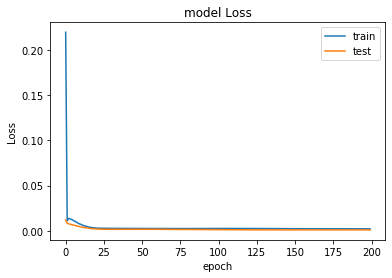

In [36]:
model_mlp = Model_Build('MLP', nodes_mlp, X_train_mlp, optimizer, learning_rate)
history_mlp = model_mlp.fit(X_train_mlp, Y_train_mlp, validation_split=validation_split, epochs=200,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Train on 552 samples, validate on 184 samples
Epoch 1/100
552/552 [==============================] - 0s 408us/step - loss: 0.1746 - accuracy: 0.0000e+00 - mse: 0.1746 - val_loss: 0.0380 - val_accuracy: 0.0000e+00 - val_mse: 0.0380
Epoch 2/100
552/552 [==============================] - 0s 145us/step - loss: 0.0209 - accuracy: 0.0018 - mse: 0.0209 - val_loss: 0.0075 - val_accuracy: 0.0000e+00 - val_mse: 0.0075
Epoch 3/100
552/552 [==============================] - 0s 149us/step - loss: 0.0129 - accuracy: 0.0018 - mse: 0.0129 - val_loss: 0.0071 - val_accuracy: 0.0000e+00 - val_mse: 0.0071
Epoch 4/100
552/552 [==============================] - 0s 157us/step - loss: 0.0115 - accuracy: 0.0018 - mse: 0.0115 - val_loss: 0.0067 - val_accuracy: 0.0000e+00 - val_mse: 0.0067
Epoch 5/100
552/552 [==============================] - 0s 126us/step - loss: 0.0104 - accuracy: 0.0018 - mse: 0.0104 - val_loss: 0.0062 - val_accuracy: 0.0000e+00 - val_mse: 0.0062
Epoch 6/100
552/552 [========================

Epoch 46/100
552/552 [==============================] - 0s 131us/step - loss: 0.0032 - accuracy: 0.0018 - mse: 0.0032 - val_loss: 0.0025 - val_accuracy: 0.0000e+00 - val_mse: 0.0025
Epoch 47/100
552/552 [==============================] - 0s 101us/step - loss: 0.0032 - accuracy: 0.0018 - mse: 0.0032 - val_loss: 0.0025 - val_accuracy: 0.0000e+00 - val_mse: 0.0025
Epoch 48/100
552/552 [==============================] - 0s 97us/step - loss: 0.0032 - accuracy: 0.0018 - mse: 0.0032 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - val_mse: 0.0024
Epoch 49/100
552/552 [==============================] - 0s 106us/step - loss: 0.0032 - accuracy: 0.0018 - mse: 0.0032 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - val_mse: 0.0024
Epoch 50/100
552/552 [==============================] - 0s 97us/step - loss: 0.0032 - accuracy: 0.0018 - mse: 0.0032 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - val_mse: 0.0024
Epoch 51/100
552/552 [==============================] - 0s 99us/step - loss: 0.0032 - accura

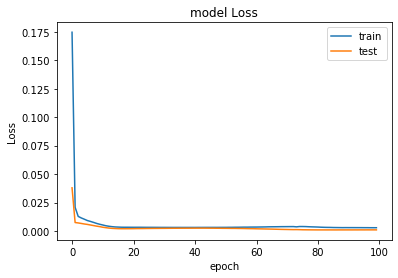

In [37]:
# 50 epochs are enough for training the model.
model_mlp = Model_Build('MLP', nodes_mlp, X_train_mlp, optimizer, learning_rate)
history_mlp = model_mlp.fit(X_train_mlp, Y_train_mlp, epochs=100,validation_split=validation_split,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/Loading Model:

In [38]:
model_mlp.save('/home/ahmada59/py/AAL_MLP.h5')
# to load the model:
# model_mlp = load_model('/home/ahmada59/py/AAL_MLP.h5')

We do one-step ahead recursive forecasting. x_test provides real values to the model for predicting. 

In [39]:
trainprediction_mlp = model_mlp.predict(X_train_mlp)
testprediction_mlp = model_mlp.predict(X_test_mlp)
trainprediction_mlp = pd.DataFrame(index=df.index[lag_mlp:len(df)-len(X_test_mlp)], data=trainprediction_mlp)
testprediction_mlp = pd.DataFrame(index=df.index[len(df)-len(X_test_mlp):], data=testprediction_mlp)

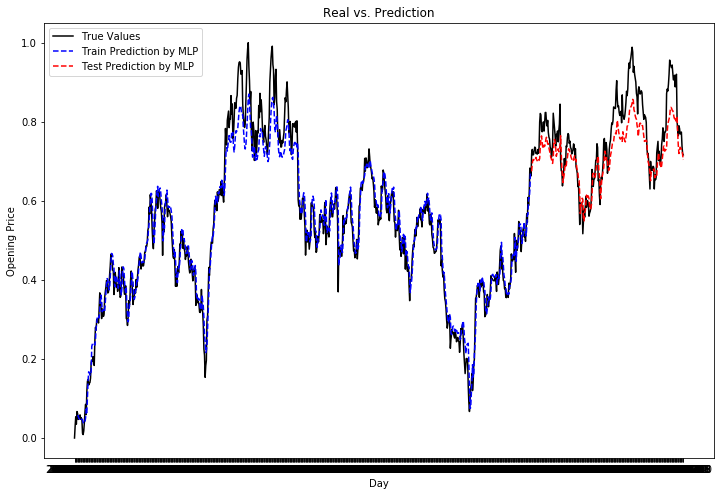

In [40]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_mlp, '--b')
plt.plot(testprediction_mlp, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Opening Price')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by MLP', 'Test Prediction by MLP'], loc='best')
plt.show()

In [41]:
Metrics['RMSE_MLP'] = RMSE(Y_test_mlp, testprediction_mlp)
Metrics['MAPE_MLP'] = MAPE(Y_test_mlp, testprediction_mlp)
Metrics['SMAPE_MLP'] = SMAPE(Y_test_mlp, testprediction_mlp)
Metrics['MSLE_MLP'] = MSLE(Y_test_mlp, testprediction_mlp)
Metrics

{'RMSE_ARIMA': 0.028961775944481898,
 'MAPE_ARIMA': 15.086972725254943,
 'SMAPE_ARIMA': 3688.863670027969,
 'MSLE_ARIMA': 0.0002764741351409335,
 'RMSE_MLP': 0.05865855739759832,
 'MAPE_MLP': 12.808137198116523,
 'SMAPE_MLP': 3278.6875020322327,
 'MSLE_MLP': 0.0010529729107367854}

# Vanilla LSTM

LSTM  can be used for univariate and multivariate time series forecasting. 
The input to the first LSTM layer has this shape: [n_steps,n_features]. n_steps is the lag of the time series or
number of lags included for training the model.
and n_features is the number of features per time step. For univariate time series, n_features is equal to 1.
for multivariate time series it is equal to the number of features.
n_samples is the number of samples we feed into deep network.
All LSTM models can be used in this way.
Remember that The input for LSTMs must be three dimensional. where the thir dimention denotes number of features. the input is in this shape: [n_samples, n_steps, n_features]

In [42]:
def input_output_generator_LSTM(z,n):
    #generating input output sets for LSTM models
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    x_train_lstm = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
    x_test_lstm = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
    return x_train_lstm, np.array(y_train), x_test_lstm, np.array(y_test)

In [43]:
lag_lstm = 3
X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm = input_output_generator_LSTM(df['Open'].tolist(),
                                                                                   lag_lstm)

In [44]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad', 'SGD', 'RMSprop', 'Adadelta']
lr = [0.001, 0.01, 0.1]
e = Tune_optimizer('Vanilla LSTM', X_train_lstm, Y_train_lstm, 50, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

{'Adam, rate=0.001': 0.0012958486614799178,
 'Adam, rate=0.01': 0.002029666673970988,
 'Adam, rate=0.1': 0.027704410317882493,
 'Adagrad, rate=0.001': 0.007346256356057082,
 'Adagrad, rate=0.01': 0.0012793235332906447,
 'Adagrad, rate=0.1': 0.001150372954135811,
 'SGD, rate=0.001': 0.029261492591546347,
 'SGD, rate=0.01': 0.007558697578182595,
 'SGD, rate=0.1': 0.0013595709523714675,
 'RMSprop, rate=0.001': 0.0013876827339314528,
 'RMSprop, rate=0.01': 0.0019076706722026338,
 'RMSprop, rate=0.1': 0.01794393139425665,
 'Adadelta, rate=0.001': 0.14715839086754903,
 'Adadelta, rate=0.01': 0.011774472992967916,
 'Adadelta, rate=0.1': 0.006596891719193474}

In [665]:
# tuning number of nodes in LSTM layer
nodes = [1, 10, 50, 100, 200]
e = Tune_nodes('Vanilla LSTM', X_train_lstm, Y_train_lstm, nodes, validation_split, 50, 10, optimizer, learning_rate)
nodes = int(min(e, key=e.get))

In [659]:
#tune batch size
batch = [1, 10, 30]
e = Tune_batch('Vanilla LSTM', X_train_lstm, Y_train_lstm, nodes, validation_split, 50,
               batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

Building the model:

In [45]:
nodes = 500
batch_size=20
learning_rate = 0.01
optimizer = 'Adam'
model_lstm = Model_Build('Vanilla LSTM', nodes, X_train_lstm, optimizer, learning_rate)
model_lstm.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 500)               1004000   
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 501       
Total params: 1,004,501
Trainable params: 1,004,501
Non-trainable params: 0
_________________________________________________________________


Train on 553 samples, validate on 185 samples
Epoch 1/100
553/553 [==============================] - 1s 2ms/step - loss: 0.0133 - accuracy: 0.0018 - mse: 0.0133 - val_loss: 0.0155 - val_accuracy: 0.0000e+00 - val_mse: 0.0155
Epoch 2/100
553/553 [==============================] - 0s 853us/step - loss: 0.0113 - accuracy: 0.0018 - mse: 0.0113 - val_loss: 0.0154 - val_accuracy: 0.0000e+00 - val_mse: 0.0154
Epoch 3/100
553/553 [==============================] - 0s 841us/step - loss: 0.0094 - accuracy: 0.0018 - mse: 0.0094 - val_loss: 0.0153 - val_accuracy: 0.0000e+00 - val_mse: 0.0153
Epoch 4/100
553/553 [==============================] - 0s 827us/step - loss: 0.0076 - accuracy: 0.0018 - mse: 0.0076 - val_loss: 0.0103 - val_accuracy: 0.0000e+00 - val_mse: 0.0103
Epoch 5/100
553/553 [==============================] - 0s 822us/step - loss: 0.0049 - accuracy: 0.0018 - mse: 0.0049 - val_loss: 0.0048 - val_accuracy: 0.0000e+00 - val_mse: 0.0048
Epoch 6/100
553/553 [==============================

553/553 [==============================] - 0s 813us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 8.1237e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.1237e-04
Epoch 89/100
553/553 [==============================] - 0s 784us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 8.1259e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.1259e-04
Epoch 90/100
553/553 [==============================] - 0s 778us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 8.1308e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.1308e-04
Epoch 91/100
553/553 [==============================] - 1s 920us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 8.1356e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.1356e-04
Epoch 92/100
553/553 [==============================] - 0s 897us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 8.1378e-04 - val_accuracy: 0.0000e+00 - val_mse: 8.1378e-04
Epoch 93/100
553/553 [==============================] - 0s 791u

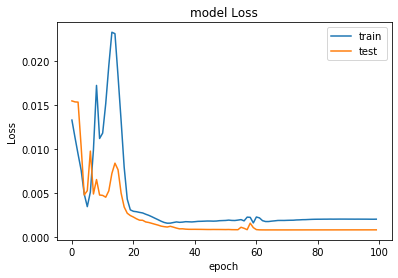

In [46]:
history_lstm = model_lstm.fit(X_train_lstm, Y_train_lstm, validation_split=validation_split, 
                              epochs=100, batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/Loadin the model:

In [47]:
model_lstm.save('/home/ahmada59/py/AAL_LSTM.h5')
# to load the model:
# model_lstm = load_model('/home/ahmada59/py/AAL_LSTM.h5')

One-step ahead recursive forecasting:

In [48]:
trainprediction_lstm = model_lstm.predict(X_train_lstm)
testprediction_lstm = model_lstm.predict(X_test_lstm)
trainprediction_lstm = pd.DataFrame(index=df.index[lag_lstm:len(df)-len(X_test_lstm)], data=trainprediction_lstm)
testprediction_lstm = pd.DataFrame(index=df.index[len(df)-len(X_test_lstm):], data=testprediction_lstm)

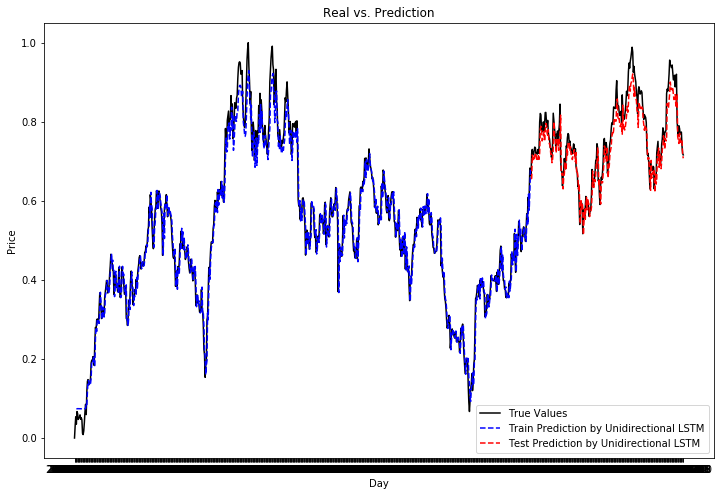

In [49]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_lstm, '--b')
plt.plot(testprediction_lstm, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Price')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by Unidirectional LSTM', 'Test Prediction by Unidirectional LSTM']
           , loc='best')
plt.show()

In [50]:
Metrics['RMSE_LSTM'] = RMSE(Y_test_lstm, testprediction_lstm)
Metrics['MAPE_LSTM'] = MAPE(Y_test_lstm, testprediction_lstm)
Metrics['SMAPE_LSTM'] = SMAPE(Y_test_lstm, testprediction_lstm)
Metrics['MSLE_LSTM'] = MSLE(Y_test_lstm, testprediction_lstm)
Metrics

{'RMSE_ARIMA': 0.028961775944481898,
 'MAPE_ARIMA': 15.086972725254943,
 'SMAPE_ARIMA': 3688.863670027969,
 'MSLE_ARIMA': 0.0002764741351409335,
 'RMSE_MLP': 0.05865855739759832,
 'MAPE_MLP': 12.808137198116523,
 'SMAPE_MLP': 3278.6875020322327,
 'MSLE_MLP': 0.0010529729107367854,
 'RMSE_LSTM': 0.03775744966846715,
 'MAPE_LSTM': 14.007053389665922,
 'SMAPE_LSTM': 3513.928807788384,
 'MSLE_LSTM': 0.0004480710650082994}

# Stacked Unidirectional LSTM

In [51]:
lag_sul = 3
X_train_sul, Y_train_sul, X_test_sul, Y_test_sul = input_output_generator_LSTM(df['Open'].tolist(),
                                                                               lag_sul)

In [67]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.1]
e = Tune_optimizer('Stacked Unidirectional LSTM', X_train_sul, Y_train_sul, [100, 100], validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

{'Adagrad, rate=0.001': 0.04647162101334996,
 'Adagrad, rate=0.1': 0.06227230059879797,
 'Adam, rate=0.001': 0.008022591626892487,
 'Adam, rate=0.1': 0.011763323995250242}

In [68]:
# tuning number of nodes in LSTM layer
nodes = [[10, 10], [50, 50], [100, 100]]
e = Tune_nodes('Stacked Unidirectional LSTM', X_train_sul, Y_train_sul, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

{0: 0.00757092371996906, 1: 0.007861944588108195, 2: 0.01084009980506919}

In [68]:
nodes = [400, 400, 400]

In [70]:
#tune batch size
batch = [10, 30]
e = Tune_batch('Stacked Unidirectional LSTM', X_train_sul, Y_train_sul, nodes, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))
e

{10: 0.014708021517705035, 30: 0.033671483397483826}

Building the model:

In [53]:
nodes = [100,50]
optimizer = 'Adam'
learning_rate = 0.001
batch_size = 100
model_sul = Model_Build('Stacked Unidirectional LSTM', nodes, X_train_sul, optimizer, learning_rate)
model_sul.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


Train on 553 samples, validate on 185 samples
Epoch 1/200
553/553 [==============================] - 1s 2ms/step - loss: 0.2675 - accuracy: 0.0000e+00 - mse: 0.2675 - val_loss: 0.1225 - val_accuracy: 0.0000e+00 - val_mse: 0.1225
Epoch 2/200
553/553 [==============================] - 0s 118us/step - loss: 0.2509 - accuracy: 0.0000e+00 - mse: 0.2509 - val_loss: 0.1107 - val_accuracy: 0.0000e+00 - val_mse: 0.1107
Epoch 3/200
553/553 [==============================] - 0s 102us/step - loss: 0.2321 - accuracy: 0.0000e+00 - mse: 0.2321 - val_loss: 0.0969 - val_accuracy: 0.0000e+00 - val_mse: 0.0969
Epoch 4/200
553/553 [==============================] - 0s 114us/step - loss: 0.2081 - accuracy: 0.0000e+00 - mse: 0.2081 - val_loss: 0.0790 - val_accuracy: 0.0000e+00 - val_mse: 0.0790
Epoch 5/200
553/553 [==============================] - 0s 128us/step - loss: 0.1744 - accuracy: 0.0000e+00 - mse: 0.1744 - val_loss: 0.0554 - val_accuracy: 0.0000e+00 - val_mse: 0.0554
Epoch 6/200
553/553 [==========

Epoch 46/200
553/553 [==============================] - 0s 106us/step - loss: 0.0037 - accuracy: 0.0018 - mse: 0.0037 - val_loss: 0.0034 - val_accuracy: 0.0000e+00 - val_mse: 0.0034
Epoch 47/200
553/553 [==============================] - 0s 102us/step - loss: 0.0036 - accuracy: 0.0018 - mse: 0.0036 - val_loss: 0.0033 - val_accuracy: 0.0000e+00 - val_mse: 0.0033
Epoch 48/200
553/553 [==============================] - 0s 94us/step - loss: 0.0036 - accuracy: 0.0018 - mse: 0.0036 - val_loss: 0.0032 - val_accuracy: 0.0000e+00 - val_mse: 0.0032
Epoch 49/200
553/553 [==============================] - 0s 93us/step - loss: 0.0036 - accuracy: 0.0018 - mse: 0.0036 - val_loss: 0.0031 - val_accuracy: 0.0000e+00 - val_mse: 0.0031
Epoch 50/200
553/553 [==============================] - 0s 84us/step - loss: 0.0035 - accuracy: 0.0018 - mse: 0.0035 - val_loss: 0.0031 - val_accuracy: 0.0000e+00 - val_mse: 0.0031
Epoch 51/200
553/553 [==============================] - 0s 88us/step - loss: 0.0035 - accurac

Epoch 136/200
553/553 [==============================] - 0s 156us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0015 - val_accuracy: 0.0000e+00 - val_mse: 0.0015
Epoch 137/200
553/553 [==============================] - 0s 106us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0015 - val_accuracy: 0.0000e+00 - val_mse: 0.0015
Epoch 138/200
553/553 [==============================] - 0s 104us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0015 - val_accuracy: 0.0000e+00 - val_mse: 0.0015
Epoch 139/200
553/553 [==============================] - 0s 98us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0015 - val_accuracy: 0.0000e+00 - val_mse: 0.0015
Epoch 140/200
553/553 [==============================] - 0s 103us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0015 - val_accuracy: 0.0000e+00 - val_mse: 0.0015
Epoch 141/200
553/553 [==============================] - 0s 92us/step - loss: 0.0023 -

Epoch 181/200
553/553 [==============================] - 0s 123us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 182/200
553/553 [==============================] - 0s 97us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 183/200
553/553 [==============================] - 0s 97us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 184/200
553/553 [==============================] - 0s 98us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 185/200
553/553 [==============================] - 0s 85us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 186/200
553/553 [==============================] - 0s 86us/step - loss: 0.0020 - ac

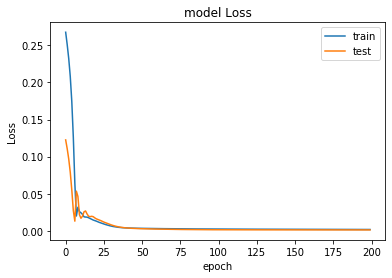

In [54]:
history_sul = model_sul.fit(X_train_sul, Y_train_sul, validation_split=validation_split, epochs=200,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_sul.history['loss'])
plt.plot(history_sul.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/Loading the Model:

In [55]:
model_sul.save('/home/ahmada59/py/AAL_SUL.h5')
# to load the model:
# model_sul = load_model('/home/ahmada59/py/AAL_SUL.h5')

One-step ahead recursive forecasting:

In [58]:
trainprediction_sul = model_sul.predict(X_train_sul)
testprediction_sul = model_sul.predict(X_test_sul)
trainprediction_sul = pd.DataFrame(index=df.index[lag_sul:len(df)-len(X_test_sul)], data=trainprediction_sul)
testprediction_sul = pd.DataFrame(index=df.index[len(df)-len(X_test_sul):], data=testprediction_sul)

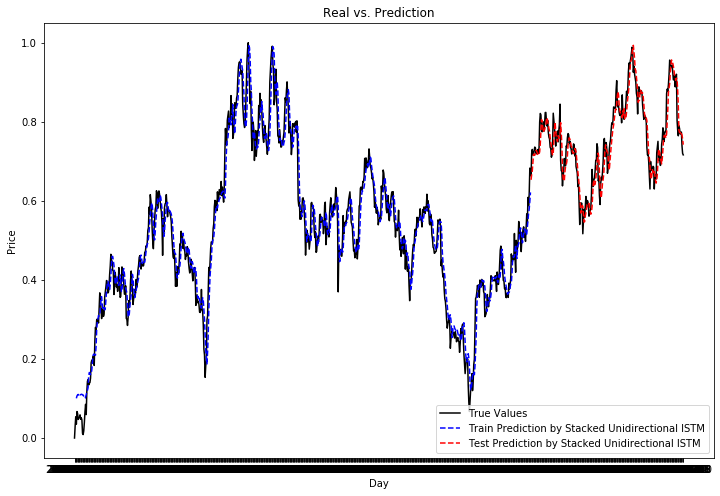

In [59]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_sul, '--b')
plt.plot(testprediction_sul, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Price')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by Stacked Unidirectional lSTM', 'Test Prediction by Stacked Unidirectional lSTM'],
           loc='best')
plt.show()

In [60]:
Metrics['RMSE_SUL'] = RMSE(Y_test_sul, testprediction_sul)
Metrics['MAPE_SUL'] = MAPE(Y_test_sul, testprediction_sul)
Metrics['SMAPE_SUL'] = SMAPE(Y_test_sul, testprediction_sul)
Metrics['MSLE_SUL'] = MSLE(Y_test_sul, testprediction_sul)
Metrics

{'RMSE_ARIMA': 0.028961775944481898,
 'MAPE_ARIMA': 15.086972725254943,
 'SMAPE_ARIMA': 3688.863670027969,
 'MSLE_ARIMA': 0.0002764741351409335,
 'RMSE_MLP': 0.05865855739759832,
 'MAPE_MLP': 12.808137198116523,
 'SMAPE_MLP': 3278.6875020322327,
 'MSLE_MLP': 0.0010529729107367854,
 'RMSE_LSTM': 0.03775744966846715,
 'MAPE_LSTM': 14.007053389665922,
 'SMAPE_LSTM': 3513.928807788384,
 'MSLE_LSTM': 0.0004480710650082994,
 'RMSE_SUL': 0.036760964167510346,
 'MAPE_SUL': 15.138478346620026,
 'SMAPE_SUL': 3705.9546542110843,
 'MSLE_SUL': 0.0004421338267157934}

# Bidirectional LSTM

In [61]:
lag_bl = 4
X_train_bl, Y_train_bl, X_test_bl, Y_test_bl = input_output_generator_LSTM(df['Open'].tolist(), lag_bl)

In [160]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.1]
e = Tune_optimizer('Bidirectional LSTM', X_train_bl, Y_train_bl, 50, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

{'Adagrad, rate=0.001': 0.0414490106481093,
 'Adagrad, rate=0.1': 0.012001787122614958,
 'Adam, rate=0.001': 0.006569595697025458,
 'Adam, rate=0.1': 0.005236387890936048}

In [161]:
# tuning number of nodes in BLSTM layer
nodes = [50, 100, 200]
e = Tune_nodes('Bidirectional LSTM', X_train_bl, Y_train_bl, nodes, validation_split, 50, 10, optimizer, learning_rate)
nodes = int(min(e, key=e.get))

In [162]:
#tune batch size
batch = [10, 30]
e = Tune_batch('Bidirectional LSTM', X_train_bl, Y_train_bl, nodes, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

building the model:

In [62]:
nodes = 100
learning_rate = 0.003
optimizer = 'Adam'
batch_size = 10
model_bl = Model_Build('Bidirectional LSTM', nodes, X_train_bl, optimizer, learning_rate)
model_bl.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 100)               81600     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 101       
Total params: 81,701
Trainable params: 81,701
Non-trainable params: 0
_________________________________________________________________


Train on 552 samples, validate on 185 samples
Epoch 1/100
552/552 [==============================] - 1s 2ms/step - loss: 0.0332 - accuracy: 0.0018 - mse: 0.0332 - val_loss: 0.0116 - val_accuracy: 0.0000e+00 - val_mse: 0.0116
Epoch 2/100
552/552 [==============================] - 0s 468us/step - loss: 0.0188 - accuracy: 0.0018 - mse: 0.0188 - val_loss: 0.0115 - val_accuracy: 0.0000e+00 - val_mse: 0.0115
Epoch 3/100
552/552 [==============================] - 0s 465us/step - loss: 0.0175 - accuracy: 0.0018 - mse: 0.0175 - val_loss: 0.0102 - val_accuracy: 0.0000e+00 - val_mse: 0.0102
Epoch 4/100
552/552 [==============================] - 0s 446us/step - loss: 0.0154 - accuracy: 0.0018 - mse: 0.0154 - val_loss: 0.0092 - val_accuracy: 0.0000e+00 - val_mse: 0.0092
Epoch 5/100
552/552 [==============================] - 0s 470us/step - loss: 0.0136 - accuracy: 0.0018 - mse: 0.0136 - val_loss: 0.0083 - val_accuracy: 0.0000e+00 - val_mse: 0.0083
Epoch 6/100
552/552 [==============================

Epoch 46/100
552/552 [==============================] - 0s 432us/step - loss: 0.0030 - accuracy: 0.0018 - mse: 0.0030 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 47/100
552/552 [==============================] - 0s 413us/step - loss: 0.0030 - accuracy: 0.0018 - mse: 0.0030 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 48/100
552/552 [==============================] - 0s 402us/step - loss: 0.0029 - accuracy: 0.0018 - mse: 0.0029 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 49/100
552/552 [==============================] - 0s 419us/step - loss: 0.0029 - accuracy: 0.0018 - mse: 0.0029 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 50/100
552/552 [==============================] - 0s 411us/step - loss: 0.0029 - accuracy: 0.0018 - mse: 0.0029 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 51/100
552/552 [==============================] - 0s 415us/step - loss: 0.0028 - acc

Epoch 90/100
552/552 [==============================] - 0s 453us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 9.2579e-04 - val_accuracy: 0.0000e+00 - val_mse: 9.2579e-04
Epoch 91/100
552/552 [==============================] - 0s 448us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 9.3968e-04 - val_accuracy: 0.0000e+00 - val_mse: 9.3968e-04
Epoch 92/100
552/552 [==============================] - 0s 413us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 9.3230e-04 - val_accuracy: 0.0000e+00 - val_mse: 9.3230e-04
Epoch 93/100
552/552 [==============================] - 0s 417us/step - loss: 0.0019 - accuracy: 0.0018 - mse: 0.0019 - val_loss: 9.3692e-04 - val_accuracy: 0.0000e+00 - val_mse: 9.3692e-04
Epoch 94/100
552/552 [==============================] - 0s 415us/step - loss: 0.0019 - accuracy: 0.0018 - mse: 0.0019 - val_loss: 9.2332e-04 - val_accuracy: 0.0000e+00 - val_mse: 9.2332e-04
Epoch 95/100
552/552 [============================

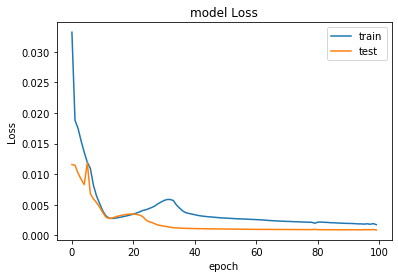

In [63]:
history_bl = model_bl.fit(X_train_bl, Y_train_bl, validation_split=validation_split, epochs=100, 
                          batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_bl.history['loss'])
plt.plot(history_bl.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/Loading the model:

In [64]:
model_bl.save('/home/ahmada59/py/AAL_BL.h5')
# to load the model:
# model_bl = load_model('/home/ahmada59/py/AAL_BL.h5')

One-step ahead recursive forecasting:

In [65]:
trainprediction_bl = model_bl.predict(X_train_bl)
testprediction_bl = model_bl.predict(X_test_bl)
trainprediction_bl = pd.DataFrame(index=df.index[lag_bl:len(df)-len(X_test_bl)], data=trainprediction_bl)
testprediction_bl = pd.DataFrame(index=df.index[len(df)-len(X_test_bl):], data=testprediction_bl)

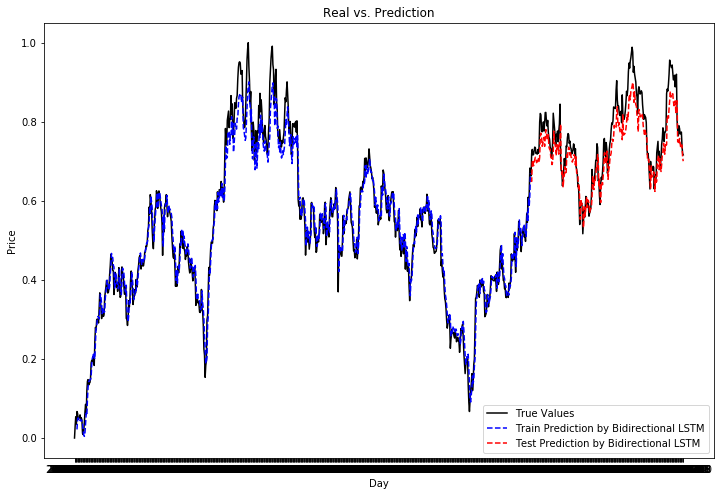

In [66]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_bl, '--b')
plt.plot(testprediction_bl, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Price')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by Bidirectional LSTM', 'Test Prediction by Bidirectional LSTM'],
           loc='best')
plt.show()

In [67]:
Metrics['RMSE_BL'] = RMSE(Y_test_bl, testprediction_bl)
Metrics['MAPE_BL'] = MAPE(Y_test_bl, testprediction_bl)
Metrics['SMAPE_BL'] = SMAPE(Y_test_bl, testprediction_bl)
Metrics['MSLE_BL'] = MSLE(Y_test_bl, testprediction_bl)
Metrics

{'RMSE_ARIMA': 0.028961775944481898,
 'MAPE_ARIMA': 15.086972725254943,
 'SMAPE_ARIMA': 3688.863670027969,
 'MSLE_ARIMA': 0.0002764741351409335,
 'RMSE_MLP': 0.05865855739759832,
 'MAPE_MLP': 12.808137198116523,
 'SMAPE_MLP': 3278.6875020322327,
 'MSLE_MLP': 0.0010529729107367854,
 'RMSE_LSTM': 0.03775744966846715,
 'MAPE_LSTM': 14.007053389665922,
 'SMAPE_LSTM': 3513.928807788384,
 'MSLE_LSTM': 0.0004480710650082994,
 'RMSE_SUL': 0.036760964167510346,
 'MAPE_SUL': 15.138478346620026,
 'SMAPE_SUL': 3705.9546542110843,
 'MSLE_SUL': 0.0004421338267157934,
 'RMSE_BL': 0.04655300350700751,
 'MAPE_BL': 13.638006774411846,
 'SMAPE_BL': 3462.407468093557,
 'MSLE_BL': 0.0006735834866830797}

# Stacked Bidirectional LSTM

In [68]:
lag_sbl = 4
X_train_sbl, Y_train_sbl, X_test_sbl, Y_test_sbl = input_output_generator_LSTM(df['Open'].tolist(),
                                                                               lag_sbl)

In [41]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.1]
e = Tune_optimizer('Stacked Bidirectional LSTM', X_train_sbl, Y_train_sbl, [50, 50], validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

{'Adagrad, rate=0.001': 0.04876123492916425,
 'Adagrad, rate=0.1': 0.010471378935983888,
 'Adam, rate=0.001': 0.00507569204395016,
 'Adam, rate=0.1': 0.0006934339719548545}

In [43]:
# tuning number of nodes in BLSTM layer
nodes = [[50, 50], [100, 100], [200, 200]]
e = Tune_nodes('Stacked Bidirectional LSTM', X_train_sbl, Y_train_sbl, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

{0: 0.017551523460834113, 1: nan, 2: nan}

In [45]:
nodes = [50, 50]

In [46]:
#tune batch size
batch = [10, 30]
e = Tune_batch('Stacked Bidirectional LSTM', X_train_sbl, Y_train_sbl, nodes, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

Building the model:

In [69]:
nodes = [200,200]
batch_size = 100
optimizer = 'Adam'
learning_rate = 0.001
model_sbl = Model_Build('Stacked Bidirectional LSTM', nodes, X_train_sbl, optimizer, learning_rate)
model_sbl.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 4, 200)            323200    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               641600    
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 201       
Total params: 965,001
Trainable params: 965,001
Non-trainable params: 0
_________________________________________________________________


Train on 552 samples, validate on 185 samples
Epoch 1/100
552/552 [==============================] - 2s 3ms/step - loss: 0.2925 - accuracy: 0.0000e+00 - mse: 0.2925 - val_loss: 0.1169 - val_accuracy: 0.0000e+00 - val_mse: 0.1169
Epoch 2/100
552/552 [==============================] - 0s 558us/step - loss: 0.2115 - accuracy: 0.0000e+00 - mse: 0.2115 - val_loss: 0.0554 - val_accuracy: 0.0000e+00 - val_mse: 0.0554
Epoch 3/100
552/552 [==============================] - 0s 566us/step - loss: 0.0920 - accuracy: 0.0000e+00 - mse: 0.0920 - val_loss: 0.0214 - val_accuracy: 0.0000e+00 - val_mse: 0.0214
Epoch 4/100
552/552 [==============================] - 0s 553us/step - loss: 0.0296 - accuracy: 0.0018 - mse: 0.0296 - val_loss: 0.0935 - val_accuracy: 0.0000e+00 - val_mse: 0.0935
Epoch 5/100
552/552 [==============================] - 0s 578us/step - loss: 0.0436 - accuracy: 0.0018 - mse: 0.0436 - val_loss: 0.0200 - val_accuracy: 0.0000e+00 - val_mse: 0.0200
Epoch 6/100
552/552 [==================

Epoch 46/100
552/552 [==============================] - 0s 553us/step - loss: 0.0031 - accuracy: 0.0018 - mse: 0.0031 - val_loss: 0.0028 - val_accuracy: 0.0000e+00 - val_mse: 0.0028
Epoch 47/100
552/552 [==============================] - 0s 508us/step - loss: 0.0030 - accuracy: 0.0018 - mse: 0.0030 - val_loss: 0.0022 - val_accuracy: 0.0000e+00 - val_mse: 0.0022
Epoch 48/100
552/552 [==============================] - 0s 503us/step - loss: 0.0029 - accuracy: 0.0018 - mse: 0.0029 - val_loss: 0.0023 - val_accuracy: 0.0000e+00 - val_mse: 0.0023
Epoch 49/100
552/552 [==============================] - 0s 584us/step - loss: 0.0028 - accuracy: 0.0018 - mse: 0.0028 - val_loss: 0.0021 - val_accuracy: 0.0000e+00 - val_mse: 0.0021
Epoch 50/100
552/552 [==============================] - 0s 506us/step - loss: 0.0028 - accuracy: 0.0018 - mse: 0.0028 - val_loss: 0.0021 - val_accuracy: 0.0000e+00 - val_mse: 0.0021
Epoch 51/100
552/552 [==============================] - 0s 503us/step - loss: 0.0026 - acc

552/552 [==============================] - 0s 693us/step - loss: 0.0018 - accuracy: 0.0018 - mse: 0.0018 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 92/100
552/552 [==============================] - 0s 509us/step - loss: 0.0019 - accuracy: 0.0018 - mse: 0.0019 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 93/100
552/552 [==============================] - 0s 558us/step - loss: 0.0018 - accuracy: 0.0018 - mse: 0.0018 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 94/100
552/552 [==============================] - 0s 553us/step - loss: 0.0019 - accuracy: 0.0018 - mse: 0.0019 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 95/100
552/552 [==============================] - 0s 528us/step - loss: 0.0018 - accuracy: 0.0018 - mse: 0.0018 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 96/100
552/552 [==============================] - 0s 520us/step - loss: 0.0019 - accuracy: 0.0018

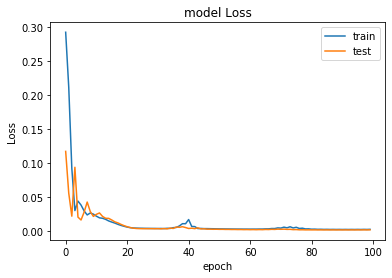

In [70]:
history_sbl = model_sbl.fit(X_train_sbl, Y_train_sbl, validation_split=validation_split, epochs=100,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_sbl.history['loss'])
plt.plot(history_sbl.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

saving/loading the model:

In [71]:
model_sbl.save('/home/ahmada59/py/AAL_SBL.h5')
# to load the model:
# model_sbl = load_model('/home/ahmada59/py/AAL_SBL.h5')

Forecast:

In [72]:
trainprediction_sbl = model_sbl.predict(X_train_sbl)
testprediction_sbl = model_sbl.predict(X_test_sbl)
trainprediction_sbl = pd.DataFrame(index=df.index[lag_sbl:len(df)-len(X_test_sbl)], data=trainprediction_sbl)
testprediction_sbl = pd.DataFrame(index=df.index[len(df)-len(X_test_sbl):], data=testprediction_sbl)

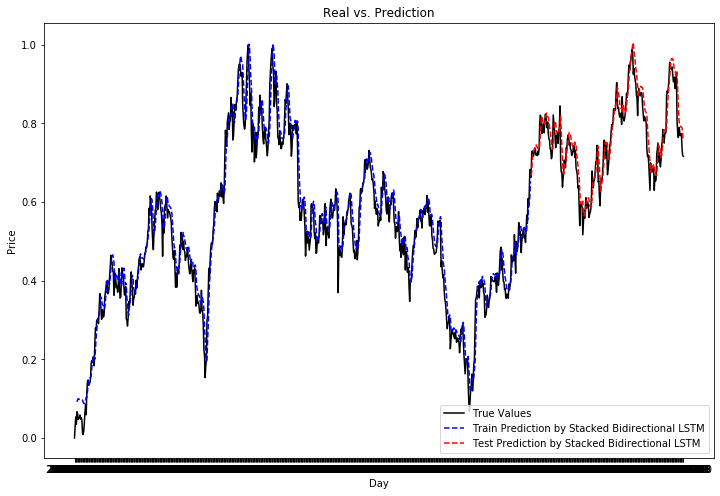

In [73]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_sbl, '--b')
plt.plot(testprediction_sbl, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Price')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by Stacked Bidirectional LSTM',
            'Test Prediction by Stacked Bidirectional LSTM'], loc='best')
plt.show()

In [74]:
Metrics['RMSE_SBL'] = RMSE(Y_test_sbl, testprediction_sbl)
Metrics['MAPE_SBL'] = MAPE(Y_test_sbl, testprediction_sbl)
Metrics['SMAPE_SBL'] = SMAPE(Y_test_sbl, testprediction_sbl)
Metrics['MSLE_SBL'] = MSLE(Y_test_sbl, testprediction_sbl)
Metrics

{'RMSE_ARIMA': 0.028961775944481898,
 'MAPE_ARIMA': 15.086972725254943,
 'SMAPE_ARIMA': 3688.863670027969,
 'MSLE_ARIMA': 0.0002764741351409335,
 'RMSE_MLP': 0.05865855739759832,
 'MAPE_MLP': 12.808137198116523,
 'SMAPE_MLP': 3278.6875020322327,
 'MSLE_MLP': 0.0010529729107367854,
 'RMSE_LSTM': 0.03775744966846715,
 'MAPE_LSTM': 14.007053389665922,
 'SMAPE_LSTM': 3513.928807788384,
 'MSLE_LSTM': 0.0004480710650082994,
 'RMSE_SUL': 0.036760964167510346,
 'MAPE_SUL': 15.138478346620026,
 'SMAPE_SUL': 3705.9546542110843,
 'MSLE_SUL': 0.0004421338267157934,
 'RMSE_BL': 0.04655300350700751,
 'MAPE_BL': 13.638006774411846,
 'SMAPE_BL': 3462.407468093557,
 'MSLE_BL': 0.0006735834866830797,
 'RMSE_SBL': 0.03752890598572265,
 'MAPE_SBL': 15.365601159984484,
 'SMAPE_SBL': 3672.139478755088,
 'MSLE_SBL': 0.00045689282229831774}

# CNN-LSTM

CNN-LSTM is composed of conv1d layers and maxpooling on input data followed by stacked LSTM layers. The conv1D
layer tries to learn and extract the features according to the filters. 
The input to the CNN has the following shape: [samples, subsequences, timesteps, features]. 


Number of features is determined by number of features in time series. If it is univariate, n_features is equal to 1. Number of subsequences is actually number of subsequences in a sequence. If each input has 10 timesteps in it for instance, it could be 1 sequence or we can divide it in 2 subsequences with 5 timesteps. 


In [75]:
def input_output_generator_CNNLSTM(z,n,n_seq):
    #generating input output sets for LSTM models
    x_train = []
    y_train = []
    x_test = []
    y_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+n])
    for i in range(len(y_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    x_train_cnnlstm = np.reshape(x_train,(x_train.shape[0], n_seq, x_train.shape[1],1))
    x_test_cnnlstm = np.reshape(x_test,(x_test.shape[0], n_seq, x_test.shape[1],1))
    return x_train_cnnlstm, np.array(y_train), x_test_cnnlstm, np.array(y_test)

In [81]:
def Model_Build_cnnlstm(n, nodes, filter_size, filter_width, X_train, optimizer, learning_rate):
    # this function creates the model. Type is the type of deep learning model. It could be MLP, LSTM, ...
    # Nodes defines the sequence of nodes in different layers of network. It should be a list.
    # Optimizer and learning rate are used for compiling the model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=filter_size, kernel_size=filter_width, activation='relu',
                                     padding='same'), input_shape=(X_train.shape[1], X_train.shape[2],
                                                                   X_train.shape[3])))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    #model.add(BatchNormalization())
    if n != 1:
        for i in range(n-1):
            model.add(TimeDistributed(Conv1D(filters=filter_size, kernel_size=filter_width, activation='relu',
                                             padding='same')))
            model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    if type(nodes) == int:
        model.add(LSTM(nodes, activation='relu', kernel_initializer='RandomUniform'))
        #model.add(Dropout(0.2))
    else:
        for i in range(len(nodes)):
            retseq = True
            if (i+1) == (len(nodes)):
                retseq = False
            model.add(LSTM(nodes[i], activation='relu', kernel_initializer='RandomUniform', return_sequences=retseq))
            #model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu', kernel_initializer='RandomUniform'))
        
    if optimizer == 'SGD':
        sgd = optimizers.SGD(lr=learning_rate, momentum=0)
        model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy', 'mse'])
    if optimizer == 'RMSprop':
        rmsprop = optimizers.RMSprop(lr=learning_rate, rho=0.9)
        model.compile(loss='mean_squared_error', optimizer=rmsprop, metrics=['accuracy', 'mse'])
    if optimizer == 'Adagrad':
        adagrad = optimizers.Adagrad(lr=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adagrad, metrics=['accuracy', 'mse'])
    if optimizer == 'Adadelta':
        adadelta = optimizers.Adadelta(lr=learning_rate, rho=0.95)
        model.compile(loss='mean_squared_error', optimizer=adadelta, metrics=['accuracy', 'mse'])
    if optimizer == 'Adam':
        adam = optimizers.Adam(learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model

In [80]:
n_seq = 1
lag_clstm = 12
X_train_clstm, Y_train_clstm, X_test_clstm, Y_test_clstm = input_output_generator_CNNLSTM(df['Open'].tolist(),
                                                                                          lag_clstm, n_seq)

In [86]:
# n defines number of cov1D layers
# nodes is a list of LSTM layers. each component is the number of LSTM nodes inside layer.
n = 2
nodes =  50
filter_size = 32
filter_width = 3
learning_rate = 0.001
optimizer = 'Adam'
batch_size = 60
model_clstm = Model_Build_cnnlstm(n, nodes, filter_size, filter_width, X_train_clstm, optimizer, learning_rate)
model_clstm.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 1, 12, 32)         128       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 1, 6, 32)          0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 1, 6, 32)          3104      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 1, 3, 32)          0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 1, 96)             0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 50)                29400     
_________________________________________________________________
dense_39 (Dense)             (None, 1)               

Train on 546 samples, validate on 183 samples
Epoch 1/120
546/546 [==============================] - 1s 2ms/step - loss: 0.3255 - accuracy: 0.0000e+00 - mse: 0.3255 - val_loss: 0.1554 - val_accuracy: 0.0000e+00 - val_mse: 0.1554
Epoch 2/120
546/546 [==============================] - 0s 84us/step - loss: 0.2756 - accuracy: 0.0000e+00 - mse: 0.2756 - val_loss: 0.1114 - val_accuracy: 0.0000e+00 - val_mse: 0.1114
Epoch 3/120
546/546 [==============================] - 0s 87us/step - loss: 0.1471 - accuracy: 0.0000e+00 - mse: 0.1471 - val_loss: 0.0219 - val_accuracy: 0.0000e+00 - val_mse: 0.0219
Epoch 4/120
546/546 [==============================] - 0s 88us/step - loss: 0.0153 - accuracy: 0.0018 - mse: 0.0153 - val_loss: 0.0085 - val_accuracy: 0.0000e+00 - val_mse: 0.0085
Epoch 5/120
546/546 [==============================] - 0s 80us/step - loss: 0.0090 - accuracy: 0.0018 - mse: 0.0090 - val_loss: 0.0064 - val_accuracy: 0.0000e+00 - val_mse: 0.0064
Epoch 6/120
546/546 [======================

Epoch 46/120
546/546 [==============================] - 0s 80us/step - loss: 0.0032 - accuracy: 0.0018 - mse: 0.0032 - val_loss: 0.0032 - val_accuracy: 0.0000e+00 - val_mse: 0.0032
Epoch 47/120
546/546 [==============================] - 0s 67us/step - loss: 0.0031 - accuracy: 0.0018 - mse: 0.0031 - val_loss: 0.0031 - val_accuracy: 0.0000e+00 - val_mse: 0.0031
Epoch 48/120
546/546 [==============================] - 0s 68us/step - loss: 0.0031 - accuracy: 0.0018 - mse: 0.0031 - val_loss: 0.0031 - val_accuracy: 0.0000e+00 - val_mse: 0.0031
Epoch 49/120
546/546 [==============================] - 0s 66us/step - loss: 0.0030 - accuracy: 0.0018 - mse: 0.0030 - val_loss: 0.0030 - val_accuracy: 0.0000e+00 - val_mse: 0.0030
Epoch 50/120
546/546 [==============================] - 0s 68us/step - loss: 0.0030 - accuracy: 0.0018 - mse: 0.0030 - val_loss: 0.0029 - val_accuracy: 0.0000e+00 - val_mse: 0.0029
Epoch 51/120
546/546 [==============================] - 0s 71us/step - loss: 0.0029 - accuracy:

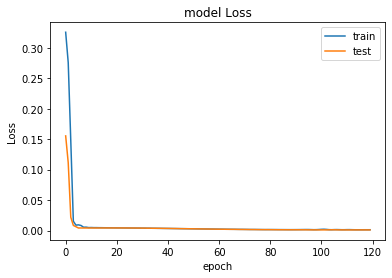

In [87]:
history_clstm = model_clstm.fit(X_train_clstm, Y_train_clstm, validation_split=validation_split,
                                epochs=120, batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_clstm.history['loss'])
plt.plot(history_clstm.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

saving/loading the model:

In [88]:
model_clstm.save('/home/ahmada59/py/AAL_CLSTM.h5')
# to load the model:
# model_clstm = load_model('/home/ahmada59/py/AAL_CLSTM.h5')

Forecasting:

In [89]:
trainprediction_clstm = model_clstm.predict(X_train_clstm)
testprediction_clstm = model_clstm.predict(X_test_clstm)
trainprediction_clstm = pd.DataFrame(index=df.index[lag_clstm:len(df)-len(X_test_clstm)], data=trainprediction_clstm)
testprediction_clstm = pd.DataFrame(index=df.index[len(df)-len(X_test_clstm):], data=testprediction_clstm)

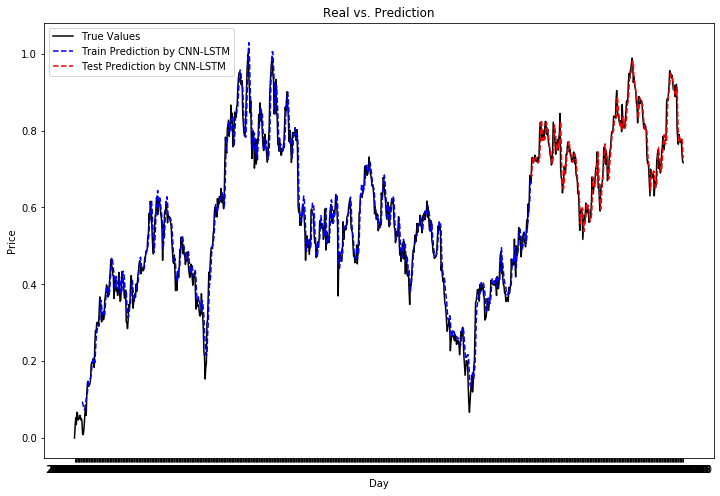

In [90]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_clstm, '--b')
plt.plot(testprediction_clstm, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Price')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by CNN-LSTM', 'Test Prediction by CNN-LSTM'], loc='best')
plt.show()

In [91]:
Metrics['RMSE_CNN-LSTM'] = RMSE(Y_test_clstm, testprediction_clstm)
Metrics['MAPE_CNN-LSTM'] = MAPE(Y_test_clstm, testprediction_clstm)
Metrics['SMAPE_CNN-LSTM'] = SMAPE(Y_test_clstm, testprediction_clstm)
Metrics['MSLE_CNN-LSTM'] = MSLE(Y_test_clstm, testprediction_clstm)
Metrics

{'RMSE_ARIMA': 0.028961775944481898,
 'MAPE_ARIMA': 15.086972725254943,
 'SMAPE_ARIMA': 3688.863670027969,
 'MSLE_ARIMA': 0.0002764741351409335,
 'RMSE_MLP': 0.05865855739759832,
 'MAPE_MLP': 12.808137198116523,
 'SMAPE_MLP': 3278.6875020322327,
 'MSLE_MLP': 0.0010529729107367854,
 'RMSE_LSTM': 0.03775744966846715,
 'MAPE_LSTM': 14.007053389665922,
 'SMAPE_LSTM': 3513.928807788384,
 'MSLE_LSTM': 0.0004480710650082994,
 'RMSE_SUL': 0.036760964167510346,
 'MAPE_SUL': 15.138478346620026,
 'SMAPE_SUL': 3705.9546542110843,
 'MSLE_SUL': 0.0004421338267157934,
 'RMSE_BL': 0.04655300350700751,
 'MAPE_BL': 13.638006774411846,
 'SMAPE_BL': 3462.407468093557,
 'MSLE_BL': 0.0006735834866830797,
 'RMSE_SBL': 0.03752890598572265,
 'MAPE_SBL': 15.365601159984484,
 'SMAPE_SBL': 3672.139478755088,
 'MSLE_SBL': 0.00045689282229831774,
 'RMSE_CNN-LSTM': 0.031296903101394685,
 'MAPE_CNN-LSTM': 14.916772628306793,
 'SMAPE_CNN-LSTM': 3637.283138778236,
 'MSLE_CNN-LSTM': 0.00032271196710881897}

# SimpleRNN

It can also be used for multivariate time series analysis.

The input shape is in this form: [timesteps, features].

The X input is 3-dimensional: [samples, timesteps, features]   

In [92]:
lag_rnn = 12
X_train_rnn, Y_train_rnn, X_test_rnn, Y_test_rnn = input_output_generator_LSTM(df['Open'].tolist(),
                                                                               lag_rnn)

In [117]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.1]
e = Tune_optimizer('SimpleRNN', X_train_rnn, Y_train_rnn, 128, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

{'Adagrad, rate=0.001': 0.07730447142212479,
 'Adagrad, rate=0.1': 0.39939527048004997,
 'Adam, rate=0.001': 0.014627588153989226,
 'Adam, rate=0.1': 0.39939527048004997}

In [118]:
# tuning number of nodes in RNN layer
nodes = [[128, 64], [64, 64], [64, 32]]
e = Tune_nodes('SimpleRNN', X_train_rnn, Y_train_rnn, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

{0: 0.07440391403657419, 1: 0.39939527048004997, 2: 0.01423214686413606}

In [121]:
nodes = [128, 64]

In [122]:
#tune batch size
batch = [10, 30]
e = Tune_batch('SimpleRNN', X_train_rnn, Y_train_rnn, nodes, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

In [97]:
nodes = 400
batch_size = 50
learning_rate = 0.0005
optimizer = 'Adam'
model_rnn = Model_Build('SimpleRNN', nodes, X_train_rnn, optimizer, learning_rate)
model_rnn.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 400)               160800    
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 401       
Total params: 161,201
Trainable params: 161,201
Non-trainable params: 0
_________________________________________________________________


Train on 546 samples, validate on 183 samples
Epoch 1/100
546/546 [==============================] - 1s 2ms/step - loss: 0.0805 - accuracy: 0.0018 - mse: 0.0805 - val_loss: 0.0107 - val_accuracy: 0.0000e+00 - val_mse: 0.0107
Epoch 2/100
546/546 [==============================] - 0s 354us/step - loss: 0.0471 - accuracy: 0.0018 - mse: 0.0471 - val_loss: 0.0227 - val_accuracy: 0.0000e+00 - val_mse: 0.0227
Epoch 3/100
546/546 [==============================] - 0s 364us/step - loss: 0.0805 - accuracy: 0.0000e+00 - mse: 0.0805 - val_loss: 0.0808 - val_accuracy: 0.0000e+00 - val_mse: 0.0808
Epoch 4/100
546/546 [==============================] - 0s 372us/step - loss: 0.0534 - accuracy: 0.0000e+00 - mse: 0.0534 - val_loss: 0.0670 - val_accuracy: 0.0000e+00 - val_mse: 0.0670
Epoch 5/100
546/546 [==============================] - 0s 375us/step - loss: 0.0348 - accuracy: 0.0018 - mse: 0.0348 - val_loss: 0.0287 - val_accuracy: 0.0000e+00 - val_mse: 0.0287
Epoch 6/100
546/546 [======================

Epoch 46/100
546/546 [==============================] - 0s 340us/step - loss: 0.0031 - accuracy: 0.0018 - mse: 0.0031 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mse: 0.0019
Epoch 47/100
546/546 [==============================] - 0s 336us/step - loss: 0.0030 - accuracy: 0.0018 - mse: 0.0030 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mse: 0.0019
Epoch 48/100
546/546 [==============================] - 0s 326us/step - loss: 0.0030 - accuracy: 0.0018 - mse: 0.0030 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mse: 0.0019
Epoch 49/100
546/546 [==============================] - 0s 419us/step - loss: 0.0030 - accuracy: 0.0018 - mse: 0.0030 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mse: 0.0019
Epoch 50/100
546/546 [==============================] - 0s 381us/step - loss: 0.0029 - accuracy: 0.0018 - mse: 0.0029 - val_loss: 0.0018 - val_accuracy: 0.0000e+00 - val_mse: 0.0018
Epoch 51/100
546/546 [==============================] - 0s 335us/step - loss: 0.0029 - acc

546/546 [==============================] - 0s 390us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 92/100
546/546 [==============================] - 0s 337us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 93/100
546/546 [==============================] - 0s 341us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 94/100
546/546 [==============================] - 0s 333us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 95/100
546/546 [==============================] - 0s 335us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 96/100
546/546 [==============================] - 0s 345us/step - loss: 0.0023 - accuracy: 0.0018

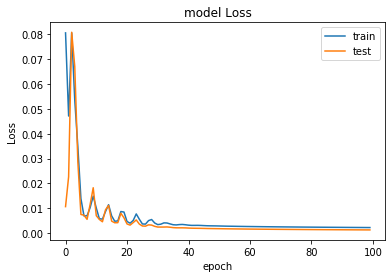

In [98]:
history_rnn = model_rnn.fit(X_train_rnn, Y_train_rnn, validation_split=validation_split, epochs=100,
                            batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

saving/loading the model:

In [99]:
model_rnn.save('/home/ahmada59/py/AAL_rnn.h5')
# to load the model:
# model_rnn = load_model('/home/ahmada59/py/AAL_rnn.h5')

Forecast:

In [100]:
trainprediction_rnn = model_rnn.predict(X_train_rnn)
testprediction_rnn = model_rnn.predict(X_test_rnn)
trainprediction_rnn = pd.DataFrame(index=df.index[lag_rnn:len(df)-len(X_test_rnn)], data=trainprediction_rnn)
testprediction_rnn = pd.DataFrame(index=df.index[len(df)-len(X_test_rnn):], data=testprediction_rnn)

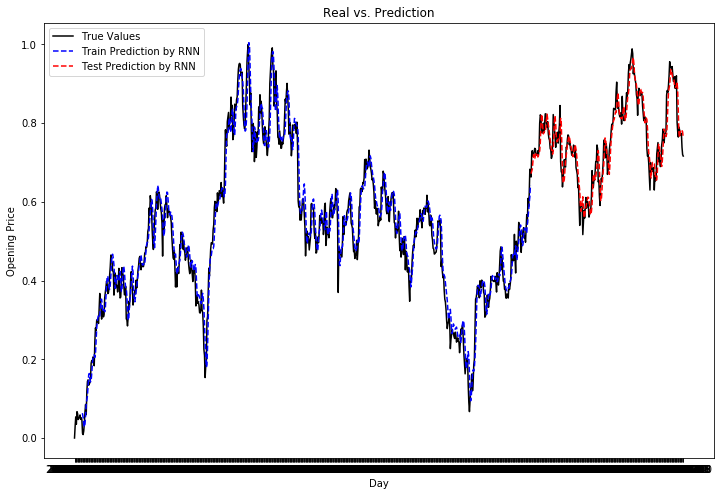

In [101]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_rnn, '--b')
plt.plot(testprediction_rnn, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Opening Price')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by RNN', 'Test Prediction by RNN'], loc='best')
plt.show()

In [102]:
Metrics['RMSE_RNN'] = RMSE(Y_test_rnn, testprediction_rnn)
Metrics['MAPE_RNN'] = MAPE(Y_test_rnn, testprediction_rnn)
Metrics['SMAPE_RNN'] = SMAPE(Y_test_rnn, testprediction_rnn)
Metrics['MSLE_RNN'] = MSLE(Y_test_rnn, testprediction_rnn)
Metrics

{'RMSE_ARIMA': 0.028961775944481898,
 'MAPE_ARIMA': 15.086972725254943,
 'SMAPE_ARIMA': 3688.863670027969,
 'MSLE_ARIMA': 0.0002764741351409335,
 'RMSE_MLP': 0.05865855739759832,
 'MAPE_MLP': 12.808137198116523,
 'SMAPE_MLP': 3278.6875020322327,
 'MSLE_MLP': 0.0010529729107367854,
 'RMSE_LSTM': 0.03775744966846715,
 'MAPE_LSTM': 14.007053389665922,
 'SMAPE_LSTM': 3513.928807788384,
 'MSLE_LSTM': 0.0004480710650082994,
 'RMSE_SUL': 0.036760964167510346,
 'MAPE_SUL': 15.138478346620026,
 'SMAPE_SUL': 3705.9546542110843,
 'MSLE_SUL': 0.0004421338267157934,
 'RMSE_BL': 0.04655300350700751,
 'MAPE_BL': 13.638006774411846,
 'SMAPE_BL': 3462.407468093557,
 'MSLE_BL': 0.0006735834866830797,
 'RMSE_SBL': 0.03752890598572265,
 'MAPE_SBL': 15.365601159984484,
 'SMAPE_SBL': 3672.139478755088,
 'MSLE_SBL': 0.00045689282229831774,
 'RMSE_CNN-LSTM': 0.031296903101394685,
 'MAPE_CNN-LSTM': 14.916772628306793,
 'SMAPE_CNN-LSTM': 3637.283138778236,
 'MSLE_CNN-LSTM': 0.00032271196710881897,
 'RMSE_RNN': 

# GRU

In [103]:
lag_gru = 12
X_train_gru, Y_train_gru, X_test_gru, Y_test_gru = input_output_generator_LSTM(df['Open'].tolist(),
                                                                               lag_gru)

In [39]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.1]
e = Tune_optimizer('GRU', X_train_gru, Y_train_gru, [128, 64], validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


{'Adam, rate=0.001': 0.006203714620184015,
 'Adam, rate=0.1': 0.15005501828811788,
 'Adagrad, rate=0.001': 0.04494460768721722,
 'Adagrad, rate=0.1': 0.004091221356281528}

In [40]:
# tuning number of nodes in RNN layer
nodes = [[128, 64], [64, 64], [64, 32]]
e = Tune_nodes('GRU', X_train_gru, Y_train_gru, nodes, validation_split, 50, 10, optimizer, learning_rate)
e

{0: 0.0031210720642573303, 1: 0.002071766294883909, 2: 0.011759170572514887}

In [41]:
nodes = [64, 64]

In [42]:
#tune batch size
batch = [10, 30]
e = Tune_batch('GRU', X_train_gru, Y_train_gru, nodes, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

Building the model:

In [104]:
nodes = 400
batch_size = 100
learning_rate = 0.001
optimizer = 'Adam'
model_gru = Model_Build('GRU', nodes, X_train_gru, optimizer, learning_rate)
model_gru.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 400)               482400    
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 401       
Total params: 482,801
Trainable params: 482,801
Non-trainable params: 0
_________________________________________________________________


Train on 546 samples, validate on 183 samples
Epoch 1/120
546/546 [==============================] - 2s 3ms/step - loss: 0.0710 - accuracy: 0.0000e+00 - mse: 0.0710 - val_loss: 0.1135 - val_accuracy: 0.0000e+00 - val_mse: 0.1135
Epoch 2/120
546/546 [==============================] - 1s 947us/step - loss: 0.0509 - accuracy: 0.0018 - mse: 0.0509 - val_loss: 0.0168 - val_accuracy: 0.0000e+00 - val_mse: 0.0168
Epoch 3/120
546/546 [==============================] - 1s 982us/step - loss: 0.0355 - accuracy: 0.0018 - mse: 0.0355 - val_loss: 0.0180 - val_accuracy: 0.0000e+00 - val_mse: 0.0180
Epoch 4/120
546/546 [==============================] - 1s 975us/step - loss: 0.0223 - accuracy: 0.0018 - mse: 0.0223 - val_loss: 0.0366 - val_accuracy: 0.0000e+00 - val_mse: 0.0366
Epoch 5/120
546/546 [==============================] - 1s 971us/step - loss: 0.0219 - accuracy: 0.0018 - mse: 0.0219 - val_loss: 0.0315 - val_accuracy: 0.0000e+00 - val_mse: 0.0315
Epoch 6/120
546/546 [==========================

Epoch 46/120
546/546 [==============================] - 1s 937us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 0.0015 - val_accuracy: 0.0000e+00 - val_mse: 0.0015
Epoch 47/120
546/546 [==============================] - 1s 927us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 0.0015 - val_accuracy: 0.0000e+00 - val_mse: 0.0015
Epoch 48/120
546/546 [==============================] - 1s 938us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 0.0015 - val_accuracy: 0.0000e+00 - val_mse: 0.0015
Epoch 49/120
546/546 [==============================] - 1s 939us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 0.0015 - val_accuracy: 0.0000e+00 - val_mse: 0.0015
Epoch 50/120
546/546 [==============================] - 1s 921us/step - loss: 0.0019 - accuracy: 0.0018 - mse: 0.0019 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 51/120
546/546 [==============================] - 0s 914us/step - loss: 0.0019 - acc

546/546 [==============================] - 0s 903us/step - loss: 0.0015 - accuracy: 0.0018 - mse: 0.0015 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mse: 0.0013
Epoch 92/120
546/546 [==============================] - 0s 907us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0022 - val_accuracy: 0.0000e+00 - val_mse: 0.0022
Epoch 93/120
546/546 [==============================] - 0s 909us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mse: 0.0013
Epoch 94/120
546/546 [==============================] - 0s 906us/step - loss: 0.0026 - accuracy: 0.0018 - mse: 0.0026 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 95/120
546/546 [==============================] - 0s 903us/step - loss: 0.0017 - accuracy: 0.0018 - mse: 0.0017 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 96/120
546/546 [==============================] - 0s 897us/step - loss: 0.0038 - accuracy: 0.0018

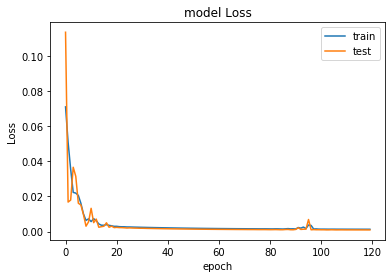

In [105]:
history_gru = model_gru.fit(X_train_gru, Y_train_gru, validation_split=validation_split,
                            epochs=120, batch_size=batch_size, verbose=1, shuffle=False)
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

saving/loading the model:

In [106]:
model_gru.save('/home/ahmada59/py/AAL_gru.h5')
# to load the model:
# model_gru = load_model('/home/ahmada59/py/AAL_gru.h5')

Forecasting:

In [107]:
trainprediction_gru = model_gru.predict(X_train_gru)
testprediction_gru = model_gru.predict(X_test_gru)
trainprediction_gru = pd.DataFrame(index=df.index[lag_gru:len(df)-len(X_test_gru)], data=trainprediction_gru)
testprediction_gru = pd.DataFrame(index=df.index[len(df)-len(X_test_gru):], data=testprediction_gru)

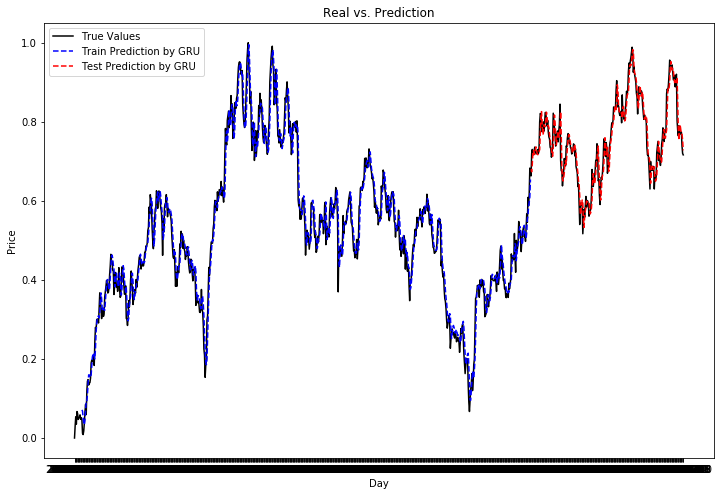

In [108]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_gru, '--b')
plt.plot(testprediction_gru, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Price')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by GRU', 'Test Prediction by GRU'], loc='best')
plt.show()

In [109]:
Metrics['RMSE_GRU'] = RMSE(Y_test_gru, testprediction_gru)
Metrics['MAPE_GRU'] = MAPE(Y_test_gru, testprediction_gru)
Metrics['SMAPE_GRU'] = SMAPE(Y_test_gru, testprediction_gru)
Metrics['MSLE_GRU'] = MSLE(Y_test_gru, testprediction_gru)
Metrics

{'RMSE_ARIMA': 0.028961775944481898,
 'MAPE_ARIMA': 15.086972725254943,
 'SMAPE_ARIMA': 3688.863670027969,
 'MSLE_ARIMA': 0.0002764741351409335,
 'RMSE_MLP': 0.05865855739759832,
 'MAPE_MLP': 12.808137198116523,
 'SMAPE_MLP': 3278.6875020322327,
 'MSLE_MLP': 0.0010529729107367854,
 'RMSE_LSTM': 0.03775744966846715,
 'MAPE_LSTM': 14.007053389665922,
 'SMAPE_LSTM': 3513.928807788384,
 'MSLE_LSTM': 0.0004480710650082994,
 'RMSE_SUL': 0.036760964167510346,
 'MAPE_SUL': 15.138478346620026,
 'SMAPE_SUL': 3705.9546542110843,
 'MSLE_SUL': 0.0004421338267157934,
 'RMSE_BL': 0.04655300350700751,
 'MAPE_BL': 13.638006774411846,
 'SMAPE_BL': 3462.407468093557,
 'MSLE_BL': 0.0006735834866830797,
 'RMSE_SBL': 0.03752890598572265,
 'MAPE_SBL': 15.365601159984484,
 'SMAPE_SBL': 3672.139478755088,
 'MSLE_SBL': 0.00045689282229831774,
 'RMSE_CNN-LSTM': 0.031296903101394685,
 'MAPE_CNN-LSTM': 14.916772628306793,
 'SMAPE_CNN-LSTM': 3637.283138778236,
 'MSLE_CNN-LSTM': 0.00032271196710881897,
 'RMSE_RNN': 

# DC-CNN: Dilated Causal Convolutional Neural Network:

Dilated Causal Convolutional Neural Networks:

Input(shape = (n_sample, timesteps, n_features)) or (batch, steps, channels)

In [110]:
def Model_Build_DCCNN(n_filters, filter_width, dilation_rates, input, nodes, dropout, optimizer, learning_rate):
    # nodes is a list containing number of nodes in each dense layer. 
    # x is the Input to the network generated by Input() function in keras. it is a placeholder for input.
    # n_filters, filter_width and dilation_rates are used in Conv1D layers.
    x = input
    for dilation_rate in dilation_rates:
        x = Conv1D(filters = n_filters, kernel_size = filter_width, padding = 'causal',
                  dilation_rate = dilation_rate)(x)
    x = Flatten()(x)
    for i in nodes:
        x = Dense(i, activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros')(x)
        if i != 1:
            x = Dropout(dropout)(x)
    model = Model(inputs = input, outputs = x)
    if optimizer == 'SGD':
        sgd = optimizers.SGD(lr=learning_rate, momentum=0)
        model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy', 'mse'])
    if optimizer == 'RMSprop':
        rmsprop = optimizers.RMSprop(lr=learning_rate, rho=0.9)
        model.compile(loss='mean_squared_error', optimizer=rmsprop, metrics=['accuracy', 'mse'])
    if optimizer == 'Adagrad':
        adagrad = optimizers.Adagrad(lr=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adagrad, metrics=['accuracy', 'mse'])
    if optimizer == 'Adadelta':
        adadelta = optimizers.Adadelta(lr=learning_rate, rho=0.95)
        model.compile(loss='mean_squared_error', optimizer=adadelta, metrics=['accuracy', 'mse'])
    if optimizer == 'Adam':
        adam = optimizers.Adam(learning_rate)
        model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model

def Tune_optimizer_DCCNN(X_train, Y_train, n_filters, filter_width, dilation_rates, input, nodes, dropout, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the optimizer and the learning rate.
    e = {}
    for i in range(len(optimizer)):
        for j in range(len(learning_rate)):
            model = Model_Build_DCCNN(n_filters, filter_width, dilation_rates, input, nodes, dropout, optimizer[i], learning_rate[j])
            history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False)
            e[optimizer[i]+', rate='+str(learning_rate[j])] = history.history['val_loss'][-1]
    return e

def Tune_batch_DCCNN(X_train, Y_train, n_filters, filter_width, dilation_rates, input, nodes, dropout, val_split, epochs, batch_size, optimizer, learning_rate):
    #this function tunes the batch size.
    e = {}
    for i in batch_size:
        model = Model_Build_DCCNN(n_filters, filter_width, dilation_rates, input, nodes, dropout, optimizer, learning_rate)
        history = model.fit(X_train, Y_train, validation_split=val_split, epochs=epochs, batch_size=i, verbose=0, shuffle=False)
        e[i] = history.history['val_loss'][-1]
    return e

In [111]:
lag_dccnn = 12
X_train_dccnn, Y_train_dccnn, X_test_dccnn, Y_test_dccnn = input_output_generator_LSTM(df['Open'].tolist(),
                                                                                       lag_dccnn)
n_filters = 32
filter_width = 3
dilation_rates = [2**i for i in range(7)]
dropout = 0.1
input = Input(shape=(X_train_dccnn.shape[1:]))
nodes = [128, 64, 32, 1]

In [132]:
#tuning optimizer. This can give us a good starting point.
opt = ['Adam', 'Adagrad']
lr = [0.001, 0.01]
e = Tune_optimizer_DCCNN(X_train_dccnn, Y_train_dccnn, n_filters, filter_width, dilation_rates, input, nodes,
                         dropout, validation_split, 50, 10, opt, lr)
optimizer = (min(e, key=e.get)).split(', ')[0]
learning_rate = float(((min(e, key=e.get)).split(', ')[1]).split('=')[1])
e

{'Adam, rate=0.001': 0.0013856445784094157,
 'Adam, rate=0.01': 0.07651403463549084,
 'Adagrad, rate=0.001': 0.011277521477529296,
 'Adagrad, rate=0.01': 0.0029255162398503336}

In [133]:
#tune batch size
batch = [10, 30]
e = Tune_batch_DCCNN(X_train_dccnn, Y_train_dccnn, n_filters, filter_width, dilation_rates, input, nodes,
                     dropout, validation_split, 50, batch, optimizer, learning_rate)
batch_size = int(min(e, key=e.get))

Building the model:

In [112]:
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(4)]
dropout = 0.1
nodes = [64, 32, 1]
optimizer = 'Adam'
learning_rate = 0.0005
batch_size = 50
model_dccnn = Model_Build_DCCNN(n_filters, filter_width, dilation_rates, input, nodes, dropout,
                                optimizer, learning_rate)
model_dccnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 1)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 12, 32)            96        
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 12, 32)            2080      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 12, 32)            2080      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 12, 32)            2080      
_________________________________________________________________
flatten_4 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 64)                2464

Train on 546 samples, validate on 183 samples
Epoch 1/100
546/546 [==============================] - 1s 2ms/step - loss: 0.3315 - accuracy: 0.0000e+00 - mse: 0.3315 - val_loss: 0.1619 - val_accuracy: 0.0000e+00 - val_mse: 0.1619
Epoch 2/100
546/546 [==============================] - 0s 149us/step - loss: 0.2807 - accuracy: 0.0000e+00 - mse: 0.2807 - val_loss: 0.1088 - val_accuracy: 0.0000e+00 - val_mse: 0.1088
Epoch 3/100
546/546 [==============================] - 0s 120us/step - loss: 0.1138 - accuracy: 0.0000e+00 - mse: 0.1138 - val_loss: 0.0065 - val_accuracy: 0.0000e+00 - val_mse: 0.0065
Epoch 4/100
546/546 [==============================] - 0s 136us/step - loss: 0.0279 - accuracy: 0.0018 - mse: 0.0279 - val_loss: 0.0081 - val_accuracy: 0.0000e+00 - val_mse: 0.0081
Epoch 5/100
546/546 [==============================] - 0s 150us/step - loss: 0.0233 - accuracy: 0.0018 - mse: 0.0233 - val_loss: 0.0064 - val_accuracy: 0.0000e+00 - val_mse: 0.0064
Epoch 6/100
546/546 [==================

Epoch 46/100
546/546 [==============================] - 0s 109us/step - loss: 0.0079 - accuracy: 0.0018 - mse: 0.0079 - val_loss: 0.0040 - val_accuracy: 0.0000e+00 - val_mse: 0.0040
Epoch 47/100
546/546 [==============================] - 0s 95us/step - loss: 0.0088 - accuracy: 0.0018 - mse: 0.0088 - val_loss: 0.0040 - val_accuracy: 0.0000e+00 - val_mse: 0.0040
Epoch 48/100
546/546 [==============================] - 0s 105us/step - loss: 0.0093 - accuracy: 0.0018 - mse: 0.0093 - val_loss: 0.0039 - val_accuracy: 0.0000e+00 - val_mse: 0.0039
Epoch 49/100
546/546 [==============================] - 0s 95us/step - loss: 0.0095 - accuracy: 0.0018 - mse: 0.0095 - val_loss: 0.0040 - val_accuracy: 0.0000e+00 - val_mse: 0.0040
Epoch 50/100
546/546 [==============================] - 0s 106us/step - loss: 0.0087 - accuracy: 0.0018 - mse: 0.0087 - val_loss: 0.0038 - val_accuracy: 0.0000e+00 - val_mse: 0.0038
Epoch 51/100
546/546 [==============================] - 0s 96us/step - loss: 0.0082 - accura

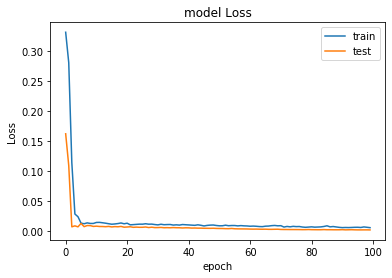

In [113]:
history_dccnn = model_dccnn.fit(X_train_dccnn, Y_train_dccnn, validation_split=validation_split,
                                epochs=100, verbose=1, batch_size=batch_size, shuffle=False)
plt.plot(history_dccnn.history['loss'])
plt.plot(history_dccnn.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/loading the model:

In [114]:
model_dccnn.save('/home/ahmada59/py/AAL_DC-CNN.h5')
# to load the model:
# model_dccnn = load_model('/home/ahmada59/py/AAL_DC-CNN.h5')

Forecasting:

In [115]:
trainprediction_dccnn = model_dccnn.predict(X_train_dccnn)
testprediction_dccnn = model_dccnn.predict(X_test_dccnn)
trainprediction_dccnn = pd.DataFrame(index=df.index[lag_dccnn:len(df)-len(X_test_dccnn)], data=trainprediction_dccnn)
testprediction_dccnn = pd.DataFrame(index=df.index[len(df)-len(X_test_dccnn):], data=testprediction_dccnn)

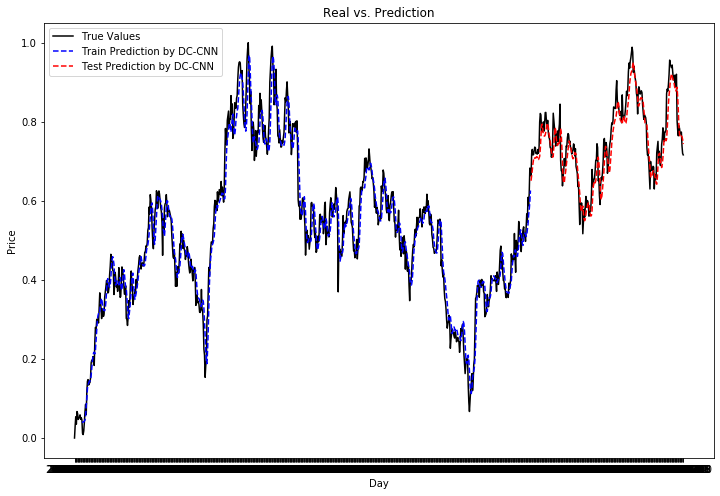

In [116]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_dccnn, '--b')
plt.plot(testprediction_dccnn, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Price')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by DC-CNN', 'Test Prediction by DC-CNN'], loc='best')
plt.show()

In [117]:
Metrics['RMSE_DCCNN'] = RMSE(Y_test_dccnn, testprediction_dccnn)
Metrics['MAPE_DCCNN'] = MAPE(Y_test_dccnn, testprediction_dccnn)
Metrics['SMAPE_DCCNN'] = SMAPE(Y_test_dccnn, testprediction_dccnn)
Metrics['MSLE_DCCNN'] = MSLE(Y_test_dccnn, testprediction_dccnn)
Metrics

{'RMSE_ARIMA': 0.028961775944481898,
 'MAPE_ARIMA': 15.086972725254943,
 'SMAPE_ARIMA': 3688.863670027969,
 'MSLE_ARIMA': 0.0002764741351409335,
 'RMSE_MLP': 0.05865855739759832,
 'MAPE_MLP': 12.808137198116523,
 'SMAPE_MLP': 3278.6875020322327,
 'MSLE_MLP': 0.0010529729107367854,
 'RMSE_LSTM': 0.03775744966846715,
 'MAPE_LSTM': 14.007053389665922,
 'SMAPE_LSTM': 3513.928807788384,
 'MSLE_LSTM': 0.0004480710650082994,
 'RMSE_SUL': 0.036760964167510346,
 'MAPE_SUL': 15.138478346620026,
 'SMAPE_SUL': 3705.9546542110843,
 'MSLE_SUL': 0.0004421338267157934,
 'RMSE_BL': 0.04655300350700751,
 'MAPE_BL': 13.638006774411846,
 'SMAPE_BL': 3462.407468093557,
 'MSLE_BL': 0.0006735834866830797,
 'RMSE_SBL': 0.03752890598572265,
 'MAPE_SBL': 15.365601159984484,
 'SMAPE_SBL': 3672.139478755088,
 'MSLE_SBL': 0.00045689282229831774,
 'RMSE_CNN-LSTM': 0.031296903101394685,
 'MAPE_CNN-LSTM': 14.916772628306793,
 'SMAPE_CNN-LSTM': 3637.283138778236,
 'MSLE_CNN-LSTM': 0.00032271196710881897,
 'RMSE_RNN': 

# SeriesNet:

Code is inspired from: https://github.com/kristpapadopoulos/seriesnet/blob/master

Source: SeriesNet: A Dilated Causal Convolutional Neural Network for Forecasting.

The network structure can be found there.

The network accepts a 3-D input as [number of samples, number of time steps, number of features] and outputs a 3D data. We will take the last time step in each sample az output (becuase in each sample the training is (t-3,t-2,t-1,t) and the test is (t-2,t-1,t,t+1) for instance). Hence we need the last time step in each sample of test data. 

In [125]:
def DCCNN_Block(n_filters, filter_width, dilation_rate, l2reg,input):
    residual = input
    layer_1 = Conv1D(filters=n_filters, kernel_size=filter_width, dilation_rate=dilation_rate, 
                    activation='linear', padding='causal', use_bias=False, 
                    kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10), 
                    kernel_regularizer=l2(l2reg))(input)    
    layer_1 = Activation('selu')(layer_1)
    skip = Conv1D(1,1, activation='linear', use_bias=False, 
                  kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
                  kernel_regularizer=l2(l2reg))(layer_1)
    layer_2 = Conv1D(1,1, activation='linear', use_bias=False, 
                     kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
                     kernel_regularizer=l2(l2reg))(layer_1)  
    To_Next_Layer = Add()([residual, layer_2])
    return To_Next_Layer, skip

def Model_Build_SN(length):
    # A function to build the seriesnet network!
    input = Input(shape=(length,1))
    n_filters = 32
    filter_width = 2
    dilation_rates = [2**i for i in range(7)] #for 7 layers.
    l2reg = 0.01
    l1a, l1b = DCCNN_Block(n_filters,filter_width,dilation_rates[0],l2reg,input)  
    l2a, l2b = DCCNN_Block(n_filters,filter_width,dilation_rates[1],l2reg,l1a) 
    l3a, l3b = DCCNN_Block(n_filters,filter_width,dilation_rates[2],l2reg,l2a)
    l4a, l4b = DCCNN_Block(n_filters,filter_width,dilation_rates[3],l2reg,l3a)
    l5a, l5b = DCCNN_Block(n_filters,filter_width,dilation_rates[4],l2reg,l4a)
    l6a, l6b = DCCNN_Block(n_filters,filter_width,dilation_rates[5],l2reg,l5a)
    l6b = Dropout(0.8)(l6b)
    l7a, l7b = DCCNN_Block(n_filters,filter_width,dilation_rates[6],l2reg,l6a)
    l7b = Dropout(0.8)(l7b) 
    l8 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b])
    l9 =   Activation('relu')(l8)
    output =  Conv1D(1,1, activation='linear', use_bias=False, 
           kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
           kernel_regularizer=l2(0.001))(l9)
    model = Model(input=input, output=output)
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model

In [126]:
def input_output_generator_SN(z,n):
    #generating input output sets for SeriesNet.
    x_train = []
    y_train = []
    x_test = []
    y_test= []
    z_test = z[math.floor(trainfrac*len(z)):]
    z_train = z[:math.floor(trainfrac*len(z))]
    for i in range(len(z_train)-n):
        x_train.append(z[i:i+n])
        y_train.append(z[i+1:i+n+1])
    for i in range(len(z_test)):
        x_test.append(z[len(z_train)-n+i:len(z_train)+i])
        y_test.append(z[len(z_train)-n+i+1:len(z_train)+i+1])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    x_train_lstm = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
    y_train_lstm = np.reshape(y_train,(y_train.shape[0], y_train.shape[1],1))
    x_test_lstm = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
    y_test_lstm = np.reshape(y_test,(y_test.shape[0], y_test.shape[1],1))
    return x_train_lstm, y_train_lstm, x_test_lstm, y_test_lstm

In [127]:
lag_sn = 12
X_train_sn, Y_train_sn, X_test_sn, Y_test_sn = input_output_generator_SN(df['Open'].tolist(), lag_sn)
model_sn = Model_Build_SN(X_train_sn.shape[1])
model_sn.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 12, 1)        0                                            
__________________________________________________________________________________________________
conv1d_56 (Conv1D)              (None, 12, 32)       64          input_4[0][0]                    
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 12, 32)       0           conv1d_56[0][0]                  
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 12, 1)        32          activation_17[0][0]              
____________________________________________________________________________________________

/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Train on 546 samples, validate on 183 samples
Epoch 1/200
546/546 [==============================] - 2s 4ms/step - loss: 0.3542 - accuracy: 0.0000e+00 - mse: 0.3402 - val_loss: 0.1863 - val_accuracy: 0.0000e+00 - val_mse: 0.1740
Epoch 2/200
546/546 [==============================] - 0s 166us/step - loss: 0.3500 - accuracy: 0.0000e+00 - mse: 0.3387 - val_loss: 0.1833 - val_accuracy: 0.0000e+00 - val_mse: 0.1735
Epoch 3/200
546/546 [==============================] - 0s 168us/step - loss: 0.3471 - accuracy: 0.0000e+00 - mse: 0.3381 - val_loss: 0.1811 - val_accuracy: 0.0000e+00 - val_mse: 0.1733
Epoch 4/200
546/546 [==============================] - 0s 172us/step - loss: 0.3450 - accuracy: 0.0000e+00 - mse: 0.3379 - val_loss: 0.1793 - val_accuracy: 0.0000e+00 - val_mse: 0.1733
Epoch 5/200
546/546 [==============================] - 0s 165us/step - loss: 0.3433 - accuracy: 0.0000e+00 - mse: 0.3379 - val_loss: 0.1779 - val_accuracy: 0.0000e+00 - val_mse: 0.1733
Epoch 6/200
546/546 [==========

Epoch 45/200
546/546 [==============================] - 0s 143us/step - loss: 0.0641 - accuracy: 0.0015 - mse: 0.0251 - val_loss: 0.0439 - val_accuracy: 0.0000e+00 - val_mse: 0.0070
Epoch 46/200
546/546 [==============================] - 0s 132us/step - loss: 0.0515 - accuracy: 0.0017 - mse: 0.0160 - val_loss: 0.0408 - val_accuracy: 0.0000e+00 - val_mse: 0.0068
Epoch 47/200
546/546 [==============================] - 0s 131us/step - loss: 0.0510 - accuracy: 0.0017 - mse: 0.0173 - val_loss: 0.0402 - val_accuracy: 0.0000e+00 - val_mse: 0.0063
Epoch 48/200
546/546 [==============================] - 0s 131us/step - loss: 0.0477 - accuracy: 0.0017 - mse: 0.0135 - val_loss: 0.0403 - val_accuracy: 0.0000e+00 - val_mse: 0.0053
Epoch 49/200
546/546 [==============================] - 0s 131us/step - loss: 0.0456 - accuracy: 0.0018 - mse: 0.0105 - val_loss: 0.0408 - val_accuracy: 0.0000e+00 - val_mse: 0.0054
Epoch 50/200
546/546 [==============================] - 0s 134us/step - loss: 0.0448 - acc

546/546 [==============================] - 0s 133us/step - loss: 0.0300 - accuracy: 0.0018 - mse: 0.0031 - val_loss: 0.0284 - val_accuracy: 0.0000e+00 - val_mse: 0.0016
Epoch 91/200
546/546 [==============================] - 0s 131us/step - loss: 0.0298 - accuracy: 0.0018 - mse: 0.0031 - val_loss: 0.0283 - val_accuracy: 0.0000e+00 - val_mse: 0.0015
Epoch 92/200
546/546 [==============================] - 0s 125us/step - loss: 0.0297 - accuracy: 0.0018 - mse: 0.0030 - val_loss: 0.0281 - val_accuracy: 0.0000e+00 - val_mse: 0.0015
Epoch 93/200
546/546 [==============================] - 0s 127us/step - loss: 0.0295 - accuracy: 0.0018 - mse: 0.0030 - val_loss: 0.0280 - val_accuracy: 0.0000e+00 - val_mse: 0.0015
Epoch 94/200
546/546 [==============================] - 0s 136us/step - loss: 0.0294 - accuracy: 0.0018 - mse: 0.0030 - val_loss: 0.0279 - val_accuracy: 0.0000e+00 - val_mse: 0.0015
Epoch 95/200
546/546 [==============================] - 0s 133us/step - loss: 0.0292 - accuracy: 0.0018

Epoch 135/200
546/546 [==============================] - 0s 156us/step - loss: 0.0252 - accuracy: 0.0018 - mse: 0.0024 - val_loss: 0.0241 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 136/200
546/546 [==============================] - 0s 162us/step - loss: 0.0251 - accuracy: 0.0018 - mse: 0.0024 - val_loss: 0.0240 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 137/200
546/546 [==============================] - 0s 145us/step - loss: 0.0250 - accuracy: 0.0018 - mse: 0.0024 - val_loss: 0.0239 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 138/200
546/546 [==============================] - 0s 135us/step - loss: 0.0250 - accuracy: 0.0018 - mse: 0.0024 - val_loss: 0.0239 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 139/200
546/546 [==============================] - 0s 129us/step - loss: 0.0249 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0238 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 140/200
546/546 [==============================] - 0s 132us/step - loss: 0.0248

Epoch 180/200
546/546 [==============================] - 0s 138us/step - loss: 0.0224 - accuracy: 0.0018 - mse: 0.0021 - val_loss: 0.0215 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 181/200
546/546 [==============================] - 0s 130us/step - loss: 0.0224 - accuracy: 0.0018 - mse: 0.0021 - val_loss: 0.0214 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 182/200
546/546 [==============================] - 0s 128us/step - loss: 0.0223 - accuracy: 0.0018 - mse: 0.0021 - val_loss: 0.0214 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 183/200
546/546 [==============================] - 0s 125us/step - loss: 0.0223 - accuracy: 0.0018 - mse: 0.0021 - val_loss: 0.0213 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 184/200
546/546 [==============================] - 0s 129us/step - loss: 0.0222 - accuracy: 0.0018 - mse: 0.0021 - val_loss: 0.0213 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 185/200
546/546 [==============================] - 0s 130us/step - loss: 0.0222

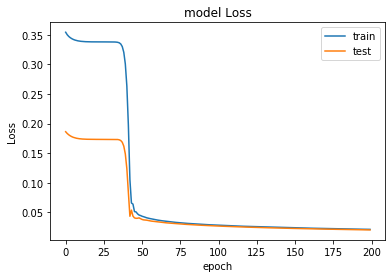

In [128]:
history_sn = model_sn.fit(X_train_sn, Y_train_sn, validation_split=validation_split, epochs=200,
                          verbose=1, batch_size=100, shuffle=False)
plt.plot(history_sn.history['loss'])
plt.plot(history_sn.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/loading the model:

In [129]:
model_sn.save('/home/ahmada59/py/AAL_SN.h5')
# to load the model:
# model_sn = load_model('/home/ahmada59/py/AAL_SN.h5')

Forecasting:

In [133]:
trainprediction_sn = model_sn.predict(X_train_sn)
testprediction_sn = model_sn.predict(X_test_sn)
trainprediction_sn = pd.DataFrame(index=df.index[lag_sn:len(df)-X_test_sn.shape[0]], data=trainprediction_sn[:,-1,:])
testprediction_sn = pd.DataFrame(index=df.index[len(df)-X_test_sn.shape[0]:], data=testprediction_sn[:,-1,:])

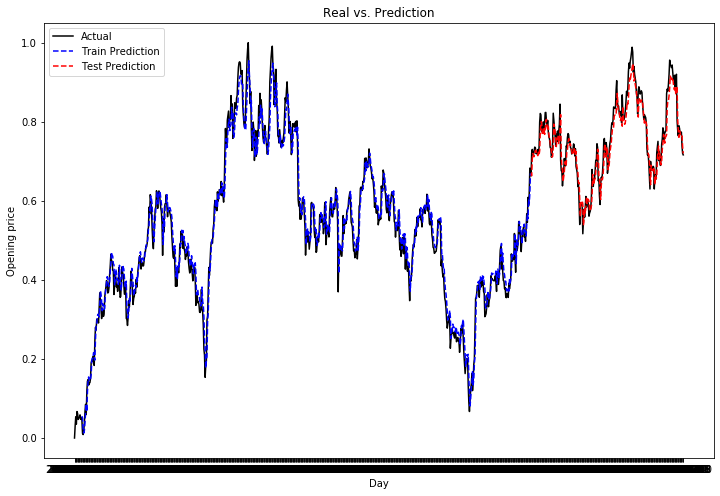

In [135]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_sn, '--b')
plt.plot(testprediction_sn, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Opening price')
plt.xlabel('Day')
plt.legend(['Actual', 'Train Prediction', 'Test Prediction'], loc='upper left')
plt.show()

In [148]:
Metrics['RMSE_SN'] = RMSE(Y_test_sn[:,11,:], testprediction_sn)
Metrics['MAPE_SN'] = MAPE(Y_test_sn[:,11,:], testprediction_sn)
Metrics['SMAPE_SN'] = SMAPE(Y_test_sn[:,11,:], testprediction_sn)
Metrics['MSLE_SN'] = MSLE(Y_test_sn[:,11,:], testprediction_sn)
Metrics

{'RMSE_ARIMA': 0.028961775944481898,
 'MAPE_ARIMA': 15.086972725254943,
 'SMAPE_ARIMA': 3688.863670027969,
 'MSLE_ARIMA': 0.0002764741351409335,
 'RMSE_MLP': 0.05865855739759832,
 'MAPE_MLP': 12.808137198116523,
 'SMAPE_MLP': 3278.6875020322327,
 'MSLE_MLP': 0.0010529729107367854,
 'RMSE_LSTM': 0.03775744966846715,
 'MAPE_LSTM': 14.007053389665922,
 'SMAPE_LSTM': 3513.928807788384,
 'MSLE_LSTM': 0.0004480710650082994,
 'RMSE_SUL': 0.036760964167510346,
 'MAPE_SUL': 15.138478346620026,
 'SMAPE_SUL': 3705.9546542110843,
 'MSLE_SUL': 0.0004421338267157934,
 'RMSE_BL': 0.04655300350700751,
 'MAPE_BL': 13.638006774411846,
 'SMAPE_BL': 3462.407468093557,
 'MSLE_BL': 0.0006735834866830797,
 'RMSE_SBL': 0.03752890598572265,
 'MAPE_SBL': 15.365601159984484,
 'SMAPE_SBL': 3672.139478755088,
 'MSLE_SBL': 0.00045689282229831774,
 'RMSE_CNN-LSTM': 0.031296903101394685,
 'MAPE_CNN-LSTM': 14.916772628306793,
 'SMAPE_CNN-LSTM': 3637.283138778236,
 'MSLE_CNN-LSTM': 0.00032271196710881897,
 'RMSE_RNN': 

# Series-Net Modified:

Here I have modified the series net network, as it accepts a 3D data same as before. But the output is just one
point. The output is the one-step ahead future timestep. I have added a Flatten layer and a Dense layer to get 
this output. The input shape is [number of samples, number of timesteps, number of features] and the output is 
[number of sample, future step].

In [149]:
def DCCNN_Block1(n_filters, filter_width, dilation_rate, l2reg,input):
    residual = input
    layer_1 = Conv1D(filters=n_filters, kernel_size=filter_width, dilation_rate=dilation_rate, 
                    activation='linear', padding='causal', use_bias=False, 
                    kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10), 
                    kernel_regularizer=l2(l2reg))(input)    
    layer_1 = Activation('selu')(layer_1)
    skip = Conv1D(1,1, activation='linear', use_bias=False, 
                  kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
                  kernel_regularizer=l2(l2reg))(layer_1)
    layer_2 = Conv1D(1,1, activation='linear', use_bias=False, 
                     kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
                     kernel_regularizer=l2(l2reg))(layer_1)  
    To_Next_Layer = Add()([residual, layer_2])
    return To_Next_Layer, skip

def Model_Build_SN1(length, n_filters, filter_width, dilation_rates,l2reg):
    # A function to build the seriesnet network!
    # length is the input size of the training data. It is number of time steps used in the training data.
    input = Input(batch_shape=(None,length,1))
    l1a, l1b = DCCNN_Block1(n_filters,filter_width,dilation_rates[0],l2reg,input)  
    l2a, l2b = DCCNN_Block1(n_filters,filter_width,dilation_rates[1],l2reg,l1a) 
    l3a, l3b = DCCNN_Block1(n_filters,filter_width,dilation_rates[2],l2reg,l2a)
    l4a, l4b = DCCNN_Block1(n_filters,filter_width,dilation_rates[3],l2reg,l3a)
    l5a, l5b = DCCNN_Block1(n_filters,filter_width,dilation_rates[4],l2reg,l4a)
    l6a, l6b = DCCNN_Block1(n_filters,filter_width,dilation_rates[5],l2reg,l5a)
    l6b = Dropout(0.7)(l6b)
    l7a, l7b = DCCNN_Block1(n_filters,filter_width,dilation_rates[6],l2reg,l6a)
    l7b = Dropout(0.7)(l7b) 
    l8 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b])
    l9 =   Activation('relu')(l8)
    l10 =  Conv1D(1,1, activation='linear', use_bias=False, 
           kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10),kernel_regularizer=l2(0.001))(l9)
    l11 = Flatten()(l10)
    output = Dense(1, activation='relu')(l11)
    model = Model(input=input, output=output)
    adam = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model

In [152]:
lag_sn1 = 6
X_train_sn1, Y_train_sn1, X_test_sn1, Y_test_sn1 = input_output_generator_LSTM(df['Open'].tolist(),
                                                                               lag_sn1)
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(7)] 
l2reg = 0
batch_size = 100
model_sn1 = Model_Build_SN1(X_train_sn1.shape[1], n_filters, filter_width, dilation_rates,l2reg)
model_sn1.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 6, 1)         0                                            
__________________________________________________________________________________________________
conv1d_100 (Conv1D)             (None, 6, 32)        64          input_6[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 6, 32)        0           conv1d_100[0][0]                 
__________________________________________________________________________________________________
conv1d_102 (Conv1D)             (None, 6, 1)         32          activation_33[0][0]              
____________________________________________________________________________________________

/home/avesta/anaconda3/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 551 samples, validate on 184 samples
Epoch 1/150
551/551 [==============================] - 2s 3ms/step - loss: 0.3369 - accuracy: 0.0000e+00 - mse: 0.3369 - val_loss: 0.1747 - val_accuracy: 0.0000e+00 - val_mse: 0.1747
Epoch 2/150
551/551 [==============================] - 0s 136us/step - loss: 0.3203 - accuracy: 0.0000e+00 - mse: 0.3203 - val_loss: 0.1474 - val_accuracy: 0.0000e+00 - val_mse: 0.1474
Epoch 3/150
551/551 [==============================] - 0s 122us/step - loss: 0.2492 - accuracy: 0.0000e+00 - mse: 0.2492 - val_loss: 0.0759 - val_accuracy: 0.0000e+00 - val_mse: 0.0759
Epoch 4/150
551/551 [==============================] - 0s 136us/step - loss: 0.0732 - accuracy: 0.0018 - mse: 0.0732 - val_loss: 0.0240 - val_accuracy: 0.0000e+00 - val_mse: 0.0240
Epoch 5/150
551/551 [==============================] - 0s 118us/step - loss: 0.0479 - accuracy: 0.0018 - mse: 0.0479 - val_loss: 0.0057 - val_accuracy: 0.0000e+00 - val_mse: 0.0056
Epoch 6/150
551/551 [==================

551/551 [==============================] - 0s 113us/step - loss: 0.0025 - accuracy: 0.0018 - mse: 0.0025 - val_loss: 0.0018 - val_accuracy: 0.0000e+00 - val_mse: 0.0018
Epoch 91/150
551/551 [==============================] - 0s 118us/step - loss: 0.0025 - accuracy: 0.0018 - mse: 0.0025 - val_loss: 0.0018 - val_accuracy: 0.0000e+00 - val_mse: 0.0018
Epoch 92/150
551/551 [==============================] - 0s 111us/step - loss: 0.0025 - accuracy: 0.0018 - mse: 0.0025 - val_loss: 0.0018 - val_accuracy: 0.0000e+00 - val_mse: 0.0018
Epoch 93/150
551/551 [==============================] - 0s 122us/step - loss: 0.0025 - accuracy: 0.0018 - mse: 0.0024 - val_loss: 0.0018 - val_accuracy: 0.0000e+00 - val_mse: 0.0017
Epoch 94/150
551/551 [==============================] - 0s 134us/step - loss: 0.0024 - accuracy: 0.0018 - mse: 0.0024 - val_loss: 0.0018 - val_accuracy: 0.0000e+00 - val_mse: 0.0017
Epoch 95/150
551/551 [==============================] - 0s 114us/step - loss: 0.0024 - accuracy: 0.0018

Epoch 135/150
551/551 [==============================] - 0s 112us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mse: 0.0013
Epoch 136/150
551/551 [==============================] - 0s 104us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mse: 0.0013
Epoch 137/150
551/551 [==============================] - 0s 112us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mse: 0.0013
Epoch 138/150
551/551 [==============================] - 0s 128us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mse: 0.0013
Epoch 139/150
551/551 [==============================] - 0s 135us/step - loss: 0.0020 - accuracy: 0.0018 - mse: 0.0020 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mse: 0.0013
Epoch 140/150
551/551 [==============================] - 0s 126us/step - loss: 0.0020

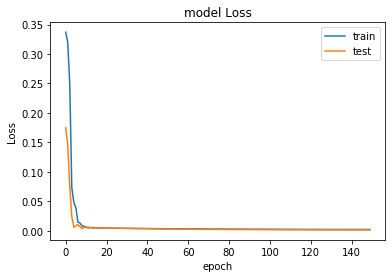

In [153]:
history_sn1 = model_sn1.fit(X_train_sn1, Y_train_sn1, validation_split=validation_split, epochs=150,
                            verbose=1, batch_size=batch_size, shuffle=False)
plt.plot(history_sn1.history['loss'])
plt.plot(history_sn1.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/loading the model:

In [154]:
model_sn1.save('/home/ahmada59/py/AAL_SN1.h5')
# to load the model:
# model_sn1 = load_model('/home/ahmada59/py/AAL_SN1.h5')

Forecasting:

In [155]:
trainprediction_sn1 = model_sn1.predict(X_train_sn1)
testprediction_sn1 = model_sn1.predict(X_test_sn1)
trainprediction_sn1 = pd.DataFrame(index=df.index[lag_sn1:len(df)-len(X_test_sn1)], data=trainprediction_sn1)
testprediction_sn1 = pd.DataFrame(index=df.index[len(df)-len(X_test_sn1):], data=testprediction_sn1)

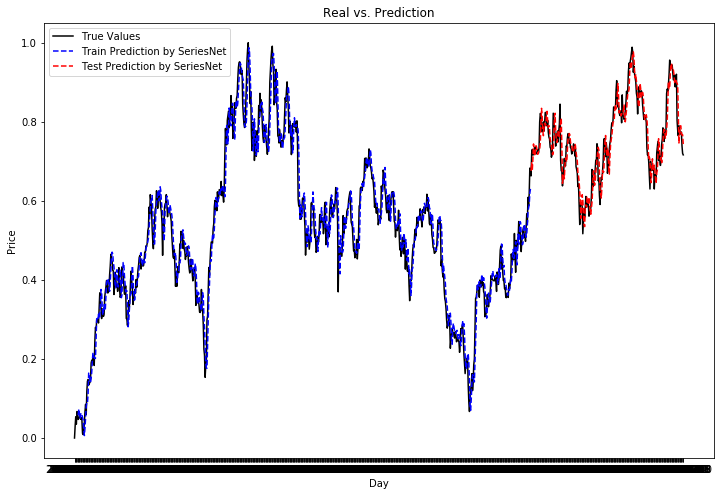

In [156]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_sn1, '--b')
plt.plot(testprediction_sn1, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Price')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by SeriesNet', 'Test Prediction by SeriesNet'], loc='best')
plt.show()

In [157]:
Metrics['RMSE_SN1'] = RMSE(Y_test_sn1, testprediction_sn1)
Metrics['MAPE_SN1'] = MAPE(Y_test_sn1, testprediction_sn1)
Metrics['SMAPE_SN1'] = SMAPE(Y_test_sn1, testprediction_sn1)
Metrics['MSLE_SN1'] = MSLE(Y_test_sn1, testprediction_sn1)
Metrics

{'RMSE_ARIMA': 0.028961775944481898,
 'MAPE_ARIMA': 15.086972725254943,
 'SMAPE_ARIMA': 3688.863670027969,
 'MSLE_ARIMA': 0.0002764741351409335,
 'RMSE_MLP': 0.05865855739759832,
 'MAPE_MLP': 12.808137198116523,
 'SMAPE_MLP': 3278.6875020322327,
 'MSLE_MLP': 0.0010529729107367854,
 'RMSE_LSTM': 0.03775744966846715,
 'MAPE_LSTM': 14.007053389665922,
 'SMAPE_LSTM': 3513.928807788384,
 'MSLE_LSTM': 0.0004480710650082994,
 'RMSE_SUL': 0.036760964167510346,
 'MAPE_SUL': 15.138478346620026,
 'SMAPE_SUL': 3705.9546542110843,
 'MSLE_SUL': 0.0004421338267157934,
 'RMSE_BL': 0.04655300350700751,
 'MAPE_BL': 13.638006774411846,
 'SMAPE_BL': 3462.407468093557,
 'MSLE_BL': 0.0006735834866830797,
 'RMSE_SBL': 0.03752890598572265,
 'MAPE_SBL': 15.365601159984484,
 'SMAPE_SBL': 3672.139478755088,
 'MSLE_SBL': 0.00045689282229831774,
 'RMSE_CNN-LSTM': 0.031296903101394685,
 'MAPE_CNN-LSTM': 14.916772628306793,
 'SMAPE_CNN-LSTM': 3637.283138778236,
 'MSLE_CNN-LSTM': 0.00032271196710881897,
 'RMSE_RNN': 

# WaveNet:

Source: WAVENET: A GENERATIVEMODEL FOR RAW AUDIO

Code is inspired from https://github.com/peustr/wavenet/blob/master/wavenet


In [164]:
def WaveNetResBlock(input, n_filters, kernel_width, dilation_rate):
    # This function builds one residual block of WaveNet model.
    output_sigmoid = Conv1D(n_filters, kernel_width, dilation_rate=dilation_rate, 
                              padding="causal", activation="sigmoid")(input)
    output_tanh = Conv1D(n_filters, kernel_width, dilation_rate=dilation_rate, 
                           padding="causal", activation="tanh")(input)
    output_mul = Multiply()([output_sigmoid, output_tanh])
    skip_connection = Conv1D(1, 1)(output_mul)
    residual = Add()([input, skip_connection])
    return residual, skip_connection

def Model_Build_WN(length, n_filters, kernel_width, num_residual_blocks):
    # This code builds the WaveNet model.
    # length: length is the number of time steps in the training set of data. If you use 12 lags
    # to train the model, input_size is 12. We assume that it is a univariate time series modeling. 
    # hence, shape of input is [number of samples, number of timesteps, 1] for one feature.
    # n_filters: Number of filters to use in the conv1D layer.
    # kernel_width: The width of the filters to use in convolutiona layers.
    # num_residual_blocks: How many residual blocks to generate between input and output. 
    # Residual block i will have a dilation rate of 2^(i+1), i starting from zero.
    # padding has been changed to causal as we are looking for causal dilated convolutions in order
    # to find get the effect of previous time steps only.
    # dilation rates will start from 1. 
    # as the output we are looking for the future time step in the sequence. So we will have one output.
    
    input = Input(batch_shape=(None,length, 1))
    layer_residual = Conv1D(n_filters, kernel_width, padding="same")(input)
    skip_connections = []
    for i in range(num_residual_blocks):
        layer_residual, layer_skip_connection = WaveNetResBlock(layer_residual, n_filters, kernel_width, 2**i)
        skip_connections.append(layer_skip_connection)
    s1 = Add()(skip_connections)
    s2 = Activation("relu")(s1)
    s3 = Conv1D(1, 1, activation="relu")(s2)
    s4 = Conv1D(1, 1)(s3)
    s5 = Flatten()(s4)
    s6 = Dense(256, activation="relu")(s5)
    output = Dense(1, activation="relu")(s6)
    model = Model(inputs=[input], outputs=[output])
    adam = optimizers.Adam(lr=0.00005)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy', 'mse'])
    return model

In [165]:
lag_wn = 12
X_train_wn, Y_train_wn, X_test_wn, Y_test_wn = input_output_generator_LSTM(df['Open'].tolist(),
                                                                           lag_wn)
n_filters = 32
kernel_width = 2
num_residual_blocks = 5
batch_size = 100
model_wn = Model_Build_WN(X_train_wn.shape[1],n_filters, kernel_width, num_residual_blocks)
model_wn.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 12, 1)        0                                            
__________________________________________________________________________________________________
conv1d_158 (Conv1D)             (None, 12, 32)       96          input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_159 (Conv1D)             (None, 12, 32)       2080        conv1d_158[0][0]                 
__________________________________________________________________________________________________
conv1d_160 (Conv1D)             (None, 12, 32)       2080        conv1d_158[0][0]                 
____________________________________________________________________________________________

Train on 546 samples, validate on 183 samples
Epoch 1/500
546/546 [==============================] - 2s 4ms/step - loss: 0.3356 - accuracy: 0.0000e+00 - mse: 0.3356 - val_loss: 0.1714 - val_accuracy: 0.0000e+00 - val_mse: 0.1714
Epoch 2/500
546/546 [==============================] - 0s 158us/step - loss: 0.3304 - accuracy: 0.0000e+00 - mse: 0.3304 - val_loss: 0.1676 - val_accuracy: 0.0000e+00 - val_mse: 0.1676
Epoch 3/500
546/546 [==============================] - 0s 156us/step - loss: 0.3238 - accuracy: 0.0000e+00 - mse: 0.3238 - val_loss: 0.1629 - val_accuracy: 0.0000e+00 - val_mse: 0.1629
Epoch 4/500
546/546 [==============================] - 0s 188us/step - loss: 0.3159 - accuracy: 0.0000e+00 - mse: 0.3159 - val_loss: 0.1578 - val_accuracy: 0.0000e+00 - val_mse: 0.1578
Epoch 5/500
546/546 [==============================] - 0s 201us/step - loss: 0.3068 - accuracy: 0.0000e+00 - mse: 0.3068 - val_loss: 0.1514 - val_accuracy: 0.0000e+00 - val_mse: 0.1514
Epoch 6/500
546/546 [==========

546/546 [==============================] - 0s 152us/step - loss: 0.0043 - accuracy: 0.0018 - mse: 0.0043 - val_loss: 0.0038 - val_accuracy: 0.0000e+00 - val_mse: 0.0038
Epoch 91/500
546/546 [==============================] - 0s 163us/step - loss: 0.0043 - accuracy: 0.0018 - mse: 0.0043 - val_loss: 0.0038 - val_accuracy: 0.0000e+00 - val_mse: 0.0038
Epoch 92/500
546/546 [==============================] - 0s 156us/step - loss: 0.0042 - accuracy: 0.0018 - mse: 0.0042 - val_loss: 0.0038 - val_accuracy: 0.0000e+00 - val_mse: 0.0038
Epoch 93/500
546/546 [==============================] - 0s 151us/step - loss: 0.0042 - accuracy: 0.0018 - mse: 0.0042 - val_loss: 0.0037 - val_accuracy: 0.0000e+00 - val_mse: 0.0037
Epoch 94/500
546/546 [==============================] - 0s 163us/step - loss: 0.0042 - accuracy: 0.0018 - mse: 0.0042 - val_loss: 0.0037 - val_accuracy: 0.0000e+00 - val_mse: 0.0037
Epoch 95/500
546/546 [==============================] - 0s 164us/step - loss: 0.0042 - accuracy: 0.0018

Epoch 135/500
546/546 [==============================] - 0s 188us/step - loss: 0.0036 - accuracy: 0.0018 - mse: 0.0036 - val_loss: 0.0030 - val_accuracy: 0.0000e+00 - val_mse: 0.0030
Epoch 136/500
546/546 [==============================] - 0s 175us/step - loss: 0.0035 - accuracy: 0.0018 - mse: 0.0035 - val_loss: 0.0030 - val_accuracy: 0.0000e+00 - val_mse: 0.0030
Epoch 137/500
546/546 [==============================] - 0s 175us/step - loss: 0.0035 - accuracy: 0.0018 - mse: 0.0035 - val_loss: 0.0030 - val_accuracy: 0.0000e+00 - val_mse: 0.0030
Epoch 138/500
546/546 [==============================] - 0s 180us/step - loss: 0.0035 - accuracy: 0.0018 - mse: 0.0035 - val_loss: 0.0030 - val_accuracy: 0.0000e+00 - val_mse: 0.0030
Epoch 139/500
546/546 [==============================] - 0s 178us/step - loss: 0.0035 - accuracy: 0.0018 - mse: 0.0035 - val_loss: 0.0029 - val_accuracy: 0.0000e+00 - val_mse: 0.0029
Epoch 140/500
546/546 [==============================] - 0s 181us/step - loss: 0.0035

Epoch 180/500
546/546 [==============================] - 0s 170us/step - loss: 0.0029 - accuracy: 0.0018 - mse: 0.0029 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - val_mse: 0.0024
Epoch 181/500
546/546 [==============================] - 0s 180us/step - loss: 0.0028 - accuracy: 0.0018 - mse: 0.0028 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - val_mse: 0.0024
Epoch 182/500
546/546 [==============================] - 0s 171us/step - loss: 0.0028 - accuracy: 0.0018 - mse: 0.0028 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - val_mse: 0.0024
Epoch 183/500
546/546 [==============================] - 0s 165us/step - loss: 0.0028 - accuracy: 0.0018 - mse: 0.0028 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - val_mse: 0.0024
Epoch 184/500
546/546 [==============================] - 0s 170us/step - loss: 0.0028 - accuracy: 0.0018 - mse: 0.0028 - val_loss: 0.0023 - val_accuracy: 0.0000e+00 - val_mse: 0.0023
Epoch 185/500
546/546 [==============================] - 0s 171us/step - loss: 0.0028

Epoch 225/500
546/546 [==============================] - 0s 218us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mse: 0.0019
Epoch 226/500
546/546 [==============================] - 0s 186us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mse: 0.0019
Epoch 227/500
546/546 [==============================] - 0s 179us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mse: 0.0019
Epoch 228/500
546/546 [==============================] - 0s 183us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mse: 0.0019
Epoch 229/500
546/546 [==============================] - 0s 176us/step - loss: 0.0023 - accuracy: 0.0018 - mse: 0.0023 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - val_mse: 0.0019
Epoch 230/500
546/546 [==============================] - 0s 177us/step - loss: 0.0023

Epoch 270/500
546/546 [==============================] - 0s 226us/step - loss: 0.0019 - accuracy: 0.0018 - mse: 0.0019 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mse: 0.0016
Epoch 271/500
546/546 [==============================] - 0s 207us/step - loss: 0.0019 - accuracy: 0.0018 - mse: 0.0019 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mse: 0.0016
Epoch 272/500
546/546 [==============================] - 0s 189us/step - loss: 0.0019 - accuracy: 0.0018 - mse: 0.0019 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mse: 0.0016
Epoch 273/500
546/546 [==============================] - 0s 180us/step - loss: 0.0019 - accuracy: 0.0018 - mse: 0.0019 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mse: 0.0016
Epoch 274/500
546/546 [==============================] - 0s 173us/step - loss: 0.0019 - accuracy: 0.0018 - mse: 0.0019 - val_loss: 0.0016 - val_accuracy: 0.0000e+00 - val_mse: 0.0016
Epoch 275/500
546/546 [==============================] - 0s 173us/step - loss: 0.0018

Epoch 315/500
546/546 [==============================] - 0s 187us/step - loss: 0.0016 - accuracy: 0.0018 - mse: 0.0016 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 316/500
546/546 [==============================] - 0s 231us/step - loss: 0.0016 - accuracy: 0.0018 - mse: 0.0016 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 317/500
546/546 [==============================] - 0s 201us/step - loss: 0.0016 - accuracy: 0.0018 - mse: 0.0016 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 318/500
546/546 [==============================] - 0s 186us/step - loss: 0.0016 - accuracy: 0.0018 - mse: 0.0016 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 319/500
546/546 [==============================] - 0s 216us/step - loss: 0.0016 - accuracy: 0.0018 - mse: 0.0016 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - val_mse: 0.0014
Epoch 320/500
546/546 [==============================] - 0s 189us/step - loss: 0.0016

Epoch 360/500
546/546 [==============================] - 0s 194us/step - loss: 0.0015 - accuracy: 0.0018 - mse: 0.0015 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mse: 0.0013
Epoch 361/500
546/546 [==============================] - 0s 174us/step - loss: 0.0015 - accuracy: 0.0018 - mse: 0.0015 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mse: 0.0013
Epoch 362/500
546/546 [==============================] - 0s 204us/step - loss: 0.0015 - accuracy: 0.0018 - mse: 0.0015 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mse: 0.0013
Epoch 363/500
546/546 [==============================] - 0s 199us/step - loss: 0.0015 - accuracy: 0.0018 - mse: 0.0015 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mse: 0.0013
Epoch 364/500
546/546 [==============================] - 0s 187us/step - loss: 0.0014 - accuracy: 0.0018 - mse: 0.0014 - val_loss: 0.0013 - val_accuracy: 0.0000e+00 - val_mse: 0.0013
Epoch 365/500
546/546 [==============================] - 0s 180us/step - loss: 0.0014

Epoch 405/500
546/546 [==============================] - 0s 207us/step - loss: 0.0014 - accuracy: 0.0018 - mse: 0.0014 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 406/500
546/546 [==============================] - 0s 180us/step - loss: 0.0014 - accuracy: 0.0018 - mse: 0.0014 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 407/500
546/546 [==============================] - 0s 187us/step - loss: 0.0013 - accuracy: 0.0018 - mse: 0.0013 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 408/500
546/546 [==============================] - 0s 175us/step - loss: 0.0013 - accuracy: 0.0018 - mse: 0.0013 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 409/500
546/546 [==============================] - 0s 181us/step - loss: 0.0013 - accuracy: 0.0018 - mse: 0.0013 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 410/500
546/546 [==============================] - 0s 181us/step - loss: 0.0013

Epoch 450/500
546/546 [==============================] - 0s 274us/step - loss: 0.0013 - accuracy: 0.0018 - mse: 0.0013 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 451/500
546/546 [==============================] - 0s 339us/step - loss: 0.0013 - accuracy: 0.0018 - mse: 0.0013 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 452/500
546/546 [==============================] - 0s 326us/step - loss: 0.0013 - accuracy: 0.0018 - mse: 0.0013 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 453/500
546/546 [==============================] - 0s 280us/step - loss: 0.0013 - accuracy: 0.0018 - mse: 0.0013 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 454/500
546/546 [==============================] - 0s 301us/step - loss: 0.0013 - accuracy: 0.0018 - mse: 0.0013 - val_loss: 0.0012 - val_accuracy: 0.0000e+00 - val_mse: 0.0012
Epoch 455/500
546/546 [==============================] - 0s 299us/step - loss: 0.0013

Epoch 495/500
546/546 [==============================] - 0s 201us/step - loss: 0.0012 - accuracy: 0.0018 - mse: 0.0012 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 496/500
546/546 [==============================] - 0s 267us/step - loss: 0.0012 - accuracy: 0.0018 - mse: 0.0012 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 497/500
546/546 [==============================] - 0s 215us/step - loss: 0.0012 - accuracy: 0.0018 - mse: 0.0012 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 498/500
546/546 [==============================] - 0s 182us/step - loss: 0.0012 - accuracy: 0.0018 - mse: 0.0012 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 499/500
546/546 [==============================] - 0s 185us/step - loss: 0.0012 - accuracy: 0.0018 - mse: 0.0012 - val_loss: 0.0011 - val_accuracy: 0.0000e+00 - val_mse: 0.0011
Epoch 500/500
546/546 [==============================] - 0s 182us/step - loss: 0.0012

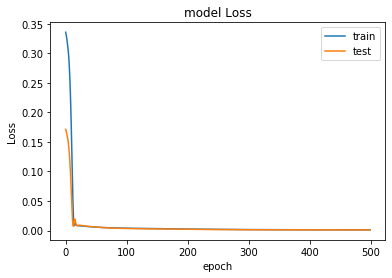

In [166]:
history_wn = model_wn.fit(X_train_wn, Y_train_wn, validation_split=validation_split, epochs=500,
                          verbose=1, batch_size=batch_size, shuffle=False)
plt.plot(history_wn.history['loss'])
plt.plot(history_wn.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Saving/Loading the model:

In [167]:
model_wn.save('/home/ahmada59/py/AAL_WN.h5')
# to load the model:
# model_wn = load_model('/home/ahmada59/py/AAL_WN.h5')

Forecasting:

In [168]:
trainprediction_wn = model_wn.predict(X_train_wn)
testprediction_wn = model_wn.predict(X_test_wn)
trainprediction_wn = pd.DataFrame(index=df.index[lag_wn:len(df)-len(X_test_wn)], data=trainprediction_wn)
testprediction_wn = pd.DataFrame(index=df.index[len(df)-len(X_test_wn):], data=testprediction_wn)

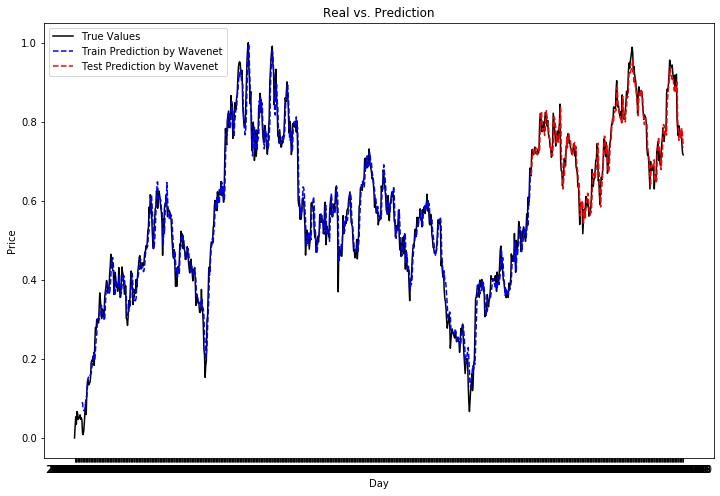

In [169]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df.Open, 'k')
plt.plot(trainprediction_wn, '--b')
plt.plot(testprediction_wn, '--r')
plt.title('Real vs. Prediction')
plt.ylabel('Price')
plt.xlabel('Day')
plt.legend(['True Values', 'Train Prediction by Wavenet', 'Test Prediction by Wavenet'], loc='best')
plt.show()

In [172]:
Metrics['RMSE_WN'] = RMSE(Y_test_wn, testprediction_wn)
Metrics['MAPE_WN'] = MAPE(Y_test_wn, testprediction_wn)
Metrics['SMAPE_WN'] = SMAPE(Y_test_wn, testprediction_wn)
Metrics['MSLE_WN'] = MSLE(Y_test_wn, testprediction_wn)
Metrics

{'RMSE_ARIMA': 0.028961775944481898,
 'MAPE_ARIMA': 15.086972725254943,
 'SMAPE_ARIMA': 3688.863670027969,
 'MSLE_ARIMA': 0.0002764741351409335,
 'RMSE_MLP': 0.05865855739759832,
 'MAPE_MLP': 12.808137198116523,
 'SMAPE_MLP': 3278.6875020322327,
 'MSLE_MLP': 0.0010529729107367854,
 'RMSE_LSTM': 0.03775744966846715,
 'MAPE_LSTM': 14.007053389665922,
 'SMAPE_LSTM': 3513.928807788384,
 'MSLE_LSTM': 0.0004480710650082994,
 'RMSE_SUL': 0.036760964167510346,
 'MAPE_SUL': 15.138478346620026,
 'SMAPE_SUL': 3705.9546542110843,
 'MSLE_SUL': 0.0004421338267157934,
 'RMSE_BL': 0.04655300350700751,
 'MAPE_BL': 13.638006774411846,
 'SMAPE_BL': 3462.407468093557,
 'MSLE_BL': 0.0006735834866830797,
 'RMSE_SBL': 0.03752890598572265,
 'MAPE_SBL': 15.365601159984484,
 'SMAPE_SBL': 3672.139478755088,
 'MSLE_SBL': 0.00045689282229831774,
 'RMSE_CNN-LSTM': 0.031296903101394685,
 'MAPE_CNN-LSTM': 14.916772628306793,
 'SMAPE_CNN-LSTM': 3637.283138778236,
 'MSLE_CNN-LSTM': 0.00032271196710881897,
 'RMSE_RNN': 

Saving the Metrics in a pickle file:

In [173]:
with open('/home/ahmada59/py/NN_AAL.pkl', 'wb') as f:
    pickle.dump(Metrics, f)
#with open('/home/ahmada59/py/NN_AAL.pkl', 'rb') as f:
#    pickle.load(f)